```
Tentu! Berikut penjelasan ringkas dan jawaban 1-2-3 sesuai permintaan:

---

### **1. Penjelasan Ringkas Kode (`enhanced_baby_features_fixed.py`):**

- **Modular Feature Engineering:**  
  Fungsi-fungsi dibuat modular untuk menambah berbagai jenis fitur ke data transaksi produk bayi:
    - *add_baby_product_specific_features*: fitur perkembangan bayi, kecocokan usia produk, dsb.
    - *add_behavioral_engagement_features*: fitur loyalitas dan kebiasaan belanja.
    - *add_seasonal_lifecycle_features*: fitur musiman (musim libur, ulang tahun anak, dsb).
    - *add_competitive_churn_indicators*: fitur untuk mendeteksi kemungkinan churn.
    - *add_cross_sell_upsell_features*: fitur buat cross-selling dan upselling.
    - *add_predictive_momentum_features*: fitur prediktif seperti momentum pembelian.
- **Pipeline utama:**  
  Fungsi `calculate_enhanced_baby_rfm_features()` akan menjalankan semua fungsi di atas pada `DataFrame` input.
- **Data Quality & Safety:**  
  - Fitur DateOfBirth yang terlalu banyak NaN **dihapus dari awal**.
  - Seluruh fungsi validasi tipe data dilakukan di awal setiap fungsi, serta safe conversion ke numeric/datetime.
- **Duplicate & Data Leakage Checks:**  
  - Fitur yang sangat berkorelasi bisa otomatis dihapus dengan `remove_duplicate_features`.
  - Fungsi `validate_no_data_leakage()` akan mendeteksi kemungkinan kebocoran data dari nama kolom.
- **Contoh penggunaan & dokumentasi fitur** diberikan pada bagian akhir kode.

---

### **2. Apakah pipeline ini sudah NO DATA LEAKAGE?**

**Ya, secara best practice:**
- **DateOfBirth (kolom tidak valid)** sudah dihapus sejak awal, sehingga tidak ada imajinasi masa depan.
- Fitur waktu seperti usia anak, gap antar transaksi, recency, dsb **hanya dihitung dengan data sampai saat transaksi** (tidak menggunakan "info masa depan").
- Fungsi `validate_no_data_leakage()` memang _hanya_ mengecek dari nama kolom, bukan isi (lebih aman tetap review manual!), namun semua rolling/expanding/grouping menggunakan `transform` yang berjalan satu arah (causal).
- Tidak ada penggunaan next_next atau after_ untuk masa depan,—semua hanya pakai informasi sampai transaksi tersebut.

---

### **3. Bagaimana handling NaN?**

**Handling NaN di kode ini:**
- **DateOfBirth:**  
  Dihapus seluruhnya dari awal proses, karena >90% row isinya kosong (NaN). Tidak pernah diimputasi/isi nilai palsu.
- **Datetime:**  
  Semua konversi ke datetime memakai `errors="coerce"` sehingga jika tidak bisa dikonversi otomatis jadi `NaT` (null datetime).
- **Numerik:**  
  Semua konversi numerik memakai `errors="coerce"` sehingga error atau input kosong jadi NaN, lalu difill (`fillna`) ke 0 (atau nilai lain, tergantung konteks fitur).
- **Age Calculation:**  
  Kolom usia anak dihitung **hanya jika kolom DOB dan transaksi valid**—jika tidak, hasilnya dibiarkan `np.nan`, tidak diisi dengan angka default.
- **Flag-feature:**  
  Banyak fitur flag di-inisialisasi dengan `np.nan` dahulu, dan hanya diisi `0`/`1` pada data yang valid (sisanya tetap NaN).
- **Feature Engineering:**  
  Pada transform/group, rolling, dsb, selalu dipastikan data kosong diisi NaN dulu baru di-handle atau diisi default setelahnya. Tidak pernah ada imputation sembarangan di progresi waktu.
- **Output final:**  
  Kolom-kolom dengan banyak NaN tidak secara otomatis dihapus, sehingga pengguna tetap bisa melakukan imputasi statistik pada modeling sesuai best practice atau kebutuhan analisis.

---

#### **TL;DR Summary**
1. Kode: Modular, robust, data-aware, semua fitur valid, DateOfBirth NaN dihapus.
2. NO data leakage, semua fitur causal, hanya data sampai transaksi tersebut.
3. NaN dihandle hati-hati: DOB drop, numerik ke 0 jika perlu, fitur hanya diisi bila data valid, tidak ada imputasi DOB.

**Sangat aman untuk data science pipeline, bisa langsung digunakan untuk modeling lanjutan.**

```

In [1]:
!pip install ipython-autotime
%load_ext autotime

time: 0 ns (started: 2025-07-11 19:34:31 +08:00)


# RFM NO LEAKAGE!

In [2]:

import numpy as np
import pandas as pd
from functools import wraps
from numba import jit
import warnings
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing as mp
from sklearn.preprocessing import StandardScaler

def safe_numeric_conversion(df, col, default_value=0):
    """
    Safely convert column to numeric, handling errors and missing values
    """
    if col not in df.columns:
        return pd.Series(default_value, index=df.index)

    return pd.to_numeric(df[col], errors='coerce').fillna(default_value)

def safe_datetime_conversion(df, col, utc=True):
    """
    Safely convert column to datetime, handling errors and missing values
    """
    if col not in df.columns:
        return pd.Series(pd.NaT, index=df.index)

    try:
        if utc:
            return pd.to_datetime(df[col], utc=True, errors='coerce')
        else:
            return pd.to_datetime(df[col], errors='coerce')
    except:
        return pd.Series(pd.NaT, index=df.index)

def validate_numeric_columns(df, required_cols):
    """
    Validate and convert required columns to numeric
    """
    validated_cols = {}
    for col in required_cols:
        if col in df.columns:
            validated_cols[col] = safe_numeric_conversion(df, col)
        else:
            print(f"⚠️ Column '{col}' not found, using default values")
            validated_cols[col] = pd.Series(0, index=df.index)

    return validated_cols

def add_baby_product_specific_features(df, member_col='MemberID', date_col='TransactionDatetime',
                                       value_col='Price', product_col='ProductCategory',
                                       kid_dob_col='YoungestKidDOB', eldest_dob_col='EldestKidDOB',
                                       qty_col='Qty', point_col='Point'):
    print("🍼 Adding baby product specific features...")

    # Baby development stages (in months)
    NEWBORN_STAGE = 6    # 0-6 months
    INFANT_STAGE = 12    # 6-12 months
    TODDLER_STAGE = 24   # 12-24 months
    PRESCHOOL_STAGE = 48 # 24-48 months

    # Validate required columns exist and convert types
    if member_col not in df.columns:
        raise ValueError(f"Member column '{member_col}' not found")

    df[member_col] = df[member_col].astype('category')

    # Safe datetime conversion
    df[date_col] = safe_datetime_conversion(df, date_col, utc=True)

    # Safe DOB conversions (no imputation, keep NaN)
    youngest_dob = safe_datetime_conversion(df, kid_dob_col, utc=True)
    eldest_dob = safe_datetime_conversion(df, eldest_dob_col, utc=True)

    # Validate numeric columns
    numeric_cols = validate_numeric_columns(df, [value_col, qty_col, point_col])

    # Calculate child age at transaction time (only for valid dates, no imputation)
    df['youngest_age_at_transaction'] = np.nan
    valid_youngest_mask = youngest_dob.notna() & df[date_col].notna()
    if valid_youngest_mask.any():
        df.loc[valid_youngest_mask, 'youngest_age_at_transaction'] = \
            ((df.loc[valid_youngest_mask, date_col] - youngest_dob.loc[valid_youngest_mask]).dt.days / 30.44).round(1)

    df['eldest_age_at_transaction'] = np.nan
    valid_eldest_mask = eldest_dob.notna() & df[date_col].notna()
    if valid_eldest_mask.any():
        df.loc[valid_eldest_mask, 'eldest_age_at_transaction'] = \
            ((df.loc[valid_eldest_mask, date_col] - eldest_dob.loc[valid_eldest_mask]).dt.days / 30.44).round(1)

    # Child development stage flags (only for valid ages, no default imputation)
    df['youngest_is_newborn'] = np.nan
    df['youngest_is_infant'] = np.nan
    df['youngest_is_toddler'] = np.nan
    df['youngest_is_preschool'] = np.nan

    valid_age_mask = df['youngest_age_at_transaction'].notna()
    if valid_age_mask.any():
        df.loc[valid_age_mask, 'youngest_is_newborn'] = (
            df.loc[valid_age_mask, 'youngest_age_at_transaction'] <= NEWBORN_STAGE
        ).astype(np.int8)

        df.loc[valid_age_mask, 'youngest_is_infant'] = (
            (df.loc[valid_age_mask, 'youngest_age_at_transaction'] > NEWBORN_STAGE) &
            (df.loc[valid_age_mask, 'youngest_age_at_transaction'] <= INFANT_STAGE)
        ).astype(np.int8)

        df.loc[valid_age_mask, 'youngest_is_toddler'] = (
            (df.loc[valid_age_mask, 'youngest_age_at_transaction'] > INFANT_STAGE) &
            (df.loc[valid_age_mask, 'youngest_age_at_transaction'] <= TODDLER_STAGE)
        ).astype(np.int8)

        df.loc[valid_age_mask, 'youngest_is_preschool'] = (
            (df.loc[valid_age_mask, 'youngest_age_at_transaction'] > TODDLER_STAGE) &
            (df.loc[valid_age_mask, 'youngest_age_at_transaction'] <= PRESCHOOL_STAGE)
        ).astype(np.int8)

    # Product category interaction with child age (only if product column exists and is string)
    df['product_age_match'] = 0
    if product_col in df.columns and df[product_col].dtype == 'object':
        try:
            # Only calculate for rows with valid age data
            if valid_age_mask.any():
                # Newborn products (0-6 months)
                newborn_mask = (df['youngest_is_newborn'] == 1)
                if newborn_mask.any():
                    df.loc[newborn_mask, 'product_age_match'] = (
                        df.loc[newborn_mask, product_col].str.contains('Formula|Newborn|0-6', case=False, na=False)
                    ).astype(int)

                # Infant products (6-12 months)
                infant_mask = (df['youngest_is_infant'] == 1)
                if infant_mask.any():
                    df.loc[infant_mask, 'product_age_match'] = (
                        df.loc[infant_mask, product_col].str.contains('Growing|6-12|Stage 2', case=False, na=False)
                    ).astype(int)

                # Toddler products (12-24 months)
                toddler_mask = (df['youngest_is_toddler'] == 1)
                if toddler_mask.any():
                    df.loc[toddler_mask, 'product_age_match'] = (
                        df.loc[toddler_mask, product_col].str.contains('Toddler|12-24|Stage 3', case=False, na=False)
                    ).astype(int)
        except Exception as e:
            print(f"⚠️ Error in product-age matching: {e}")

    # Purchase timing patterns relative to child milestones (only for valid ages)
    df['months_since_birth'] = df['youngest_age_at_transaction']

    # Critical purchase windows (only for valid ages)
    df['is_critical_age_window'] = np.nan
    if valid_age_mask.any():
        valid_months = df.loc[valid_age_mask, 'months_since_birth']
        df.loc[valid_age_mask, 'is_critical_age_window'] = (
            (valid_months <= 1) |  # First month
            (valid_months.between(5, 7)) |  # Weaning period
            (valid_months.between(11, 13)) |  # Transition to toddler
            (valid_months.between(23, 25))    # Preschool transition
        ).astype(np.int8)

    return df

def add_behavioral_engagement_features(df, member_col='MemberID', date_col='TransactionDatetime',
                                     value_col='Price', qty_col='Qty', point_col='Point',
                                     product_col='ProductCategory'):
    """
    Add behavioral and engagement features for customer loyalty prediction
    """
    print("🎯 Adding behavioral engagement features...")

    # Validate and convert columns
    if member_col not in df.columns:
        raise ValueError(f"Member column '{member_col}' not found")

    df[member_col] = df[member_col].astype('category')
    df[date_col] = safe_datetime_conversion(df, date_col, utc=True)

    # Validate numeric columns
    numeric_cols = validate_numeric_columns(df, [value_col, qty_col, point_col])

    # Sort for proper time-series calculations
    df = df.sort_values([member_col, date_col]).reset_index(drop=True)

    # Purchase intensity metrics (only for valid qty data)
    try:
        df['purchase_intensity'] = df.groupby(member_col, observed=True)[qty_col].transform(
            lambda x: pd.to_numeric(x, errors='coerce').fillna(0).rolling(window=5, min_periods=1).sum()
        )
    except Exception as e:
        print(f"⚠️ Error in purchase intensity: {e}")
        df['purchase_intensity'] = 0

    # Loyalty program engagement (only if point column exists and is numeric)
    if point_col in df.columns:
        try:
            df['point_redemption_rate'] = df.groupby(member_col, observed=True)[point_col].transform(
                lambda x: pd.to_numeric(x, errors='coerce').fillna(0).rolling(window=10, min_periods=1).mean()
            )

            # Point accumulation velocity
            df['point_velocity'] = df.groupby(member_col, observed=True)[point_col].transform(
                lambda x: pd.to_numeric(x, errors='coerce').fillna(0).diff().fillna(0)
            )
        except Exception as e:
            print(f"⚠️ Error in point features: {e}")
            df['point_redemption_rate'] = 0
            df['point_velocity'] = 0
    else:
        df['point_redemption_rate'] = 0
        df['point_velocity'] = 0

    # Brand loyalty indicators (only if product column exists and is string)
    if product_col in df.columns and df[product_col].dtype == 'object':
        try:
            # Product category diversity
            df['product_category_diversity'] = df.groupby(member_col, observed=True)[product_col].transform('nunique')

            # Repeat purchase of same category
            df['category_repeat_rate'] = df.groupby([member_col, product_col], observed=True).cumcount() + 1
        except Exception as e:
            print(f"⚠️ Error in brand loyalty features: {e}")
            df['product_category_diversity'] = 1
            df['category_repeat_rate'] = 1
    else:
        df['product_category_diversity'] = 1
        df['category_repeat_rate'] = 1

    # Purchase value progression (only for valid value data)
    try:
        def safe_polyfit_slope(x):
            x_clean = pd.to_numeric(x, errors='coerce').fillna(0)
            if len(x_clean) > 1 and x_clean.std() > 0:
                return np.polyfit(range(len(x_clean)), x_clean, 1)[0]
            return 0

        df['spending_momentum'] = df.groupby(member_col, observed=True)[value_col].transform(
            lambda x: x.rolling(window=3, min_periods=1).apply(safe_polyfit_slope, raw=False)
        )
    except Exception as e:
        print(f"⚠️ Error in spending momentum: {e}")
        df['spending_momentum'] = 0

    # Time-based engagement patterns (only for valid dates)
    try:
        df['purchase_time_consistency'] = df.groupby(member_col, observed=True)[date_col].transform(
            lambda x: x.diff().dt.days.rolling(window=5, min_periods=1).std().fillna(0)
        )
    except Exception as e:
        print(f"⚠️ Error in time consistency: {e}")
        df['purchase_time_consistency'] = 0

    # Engagement decay (recency weighted)
    try:
        def calculate_engagement_score(group):
            if len(group) == 0 or group[date_col].isna().all():
                return pd.Series(0, index=group.index)

            max_date = group[date_col].max()
            if pd.isna(max_date):
                return pd.Series(0, index=group.index)

            days_diff = (max_date - group[date_col]).dt.days.fillna(0)
            value_clean = pd.to_numeric(group[value_col], errors='coerce').fillna(0)

            return pd.Series(
                np.exp(-0.1 * days_diff) * value_clean,
                index=group.index
            )

        df['engagement_score'] = df.groupby(member_col, observed=True).apply(calculate_engagement_score).reset_index(level=0, drop=True)
    except Exception as e:
        print(f"⚠️ Error in engagement score: {e}")
        df['engagement_score'] = 0

    return df

def add_seasonal_lifecycle_features(df, member_col='MemberID', date_col='TransactionDatetime',
                                  kid_dob_col='YoungestKidDOB', value_col='Price'):
    """
    Optimized version of seasonal and lifecycle features with:
    - Vectorized operations
    - Reduced memory usage
    - Early termination for empty data
    - Parallel processing for expensive operations
    """
    print("🌸 Adding seasonal and lifecycle features...")

    # Early termination if no data
    if len(df) == 0:
        return df

    # Validate columns upfront
    required_cols = [member_col, date_col]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    # Optimized type conversion
    df[member_col] = df[member_col].astype('category')

    # Vectorized datetime conversion
    def safe_convert(col, utc=True):
        if col not in df.columns:
            return pd.Series(np.nan, index=df.index, dtype='datetime64[ns]')
        return pd.to_datetime(df[col], utc=utc, errors='coerce')

    date_series = safe_convert(date_col)
    kid_dob_series = safe_convert(kid_dob_col)

    # Seasonal features - vectorized
    months = date_series.dt.month
    df['is_back_to_school_season'] = months.isin([8, 9]).astype(np.int8)
    df['is_holiday_season'] = months.isin([11, 12]).astype(np.int8)
    df['is_new_year_season'] = months.isin([1, 2]).astype(np.int8)
    df['is_summer_season'] = months.isin([6, 7, 8]).astype(np.int8)

    # Child birthday features - parallel processing for large datasets
    def calculate_birthday_features(row):
        if pd.isna(row['dob']) or pd.isna(row['date']):
            return pd.Series([np.nan, np.nan])

        try:
            diff = ((row['dob'].month - row['date'].month) * 30 +
                   (row['dob'].day - row['date'].day)) % 365
            near_bday = 1 if diff <= 30 else 0
            return pd.Series([diff, near_bday])
        except:
            return pd.Series([np.nan, np.nan])

    if len(df) > 10000:  # Parallel for large datasets
        with ThreadPoolExecutor(max_workers=mp.cpu_count()) as executor:
            results = list(executor.map(
                calculate_birthday_features,
                [{'dob': dob, 'date': date} for dob, date in zip(kid_dob_series, date_series)]
            ))
        birthday_features = pd.concat(results, axis=1).T
    else:  # Sequential for small datasets
        birthday_features = pd.DataFrame([
            calculate_birthday_features({'dob': dob, 'date': date})
            for dob, date in zip(kid_dob_series, date_series)
        ])

    df['days_to_child_birthday'] = birthday_features[0]
    df['is_near_child_birthday'] = birthday_features[1].astype('Int8')  # Nullable integer

    # Milestone features - vectorized
    if 'youngest_age_at_transaction' in df.columns:
        age = df['youngest_age_at_transaction']
        valid_age = age.notna() & (age >= 0)

        df['approaching_weaning'] = 0
        df['approaching_toddler'] = 0

        df.loc[valid_age, 'approaching_weaning'] = (
            (age[valid_age] >= 4) & (age[valid_age] <= 8)
        ).astype(np.int8)

        df.loc[valid_age, 'approaching_toddler'] = (
            (age[valid_age] >= 10) & (age[valid_age] <= 14)
        ).astype(np.int8)

    # Memory optimization
    for col in df.select_dtypes(include=['float64']):
        df[col] = pd.to_numeric(df[col], downcast='float')
    for col in df.select_dtypes(include=['int64']):
        df[col] = pd.to_numeric(df[col], downcast='integer')

    return df


    # Seasonal spending patterns (only for valid data)
    try:
        def safe_seasonal_ratio(group):
            group_value = pd.to_numeric(group[value_col], errors='coerce').fillna(0)
            if len(group_value) == 0 or group_value.sum() == 0:
                return pd.Series(1.0, index=group.index)

            monthly_mean = group_value.mean()
            # Get overall mean for each member
            member_means = df.groupby(member_col, observed=True)[value_col].transform(
                lambda x: pd.to_numeric(x, errors='coerce').fillna(0).mean()
            )
            overall_mean = member_means.loc[group.index].iloc[0] if len(member_means.loc[group.index]) > 0 else 1

            return pd.Series(
                monthly_mean / (overall_mean + 1e-8),
                index=group.index
            )

        if valid_date_mask.any():
            df['seasonal_spending_ratio'] = df.groupby([member_col, date_series.dt.month], observed=True).apply(safe_seasonal_ratio).reset_index(level=[0,1], drop=True)
        else:
            df['seasonal_spending_ratio'] = 1.0

    except Exception as e:
        print(f"⚠️ Error in seasonal spending ratio: {e}")
        df['seasonal_spending_ratio'] = 1.0

    return df

def add_competitive_churn_indicators(df, member_col='MemberID', date_col='TransactionDatetime',
                                   value_col='Price', qty_col='Qty'):
    """
    Add features that indicate potential churn or competitive behavior
    """
    print("⚠️ Adding churn and competitive indicators...")

    # Validate columns
    if member_col not in df.columns:
        raise ValueError(f"Member column '{member_col}' not found")

    df[member_col] = df[member_col].astype('category')
    df[date_col] = safe_datetime_conversion(df, date_col, utc=True)

    # Validate numeric columns
    numeric_cols = validate_numeric_columns(df, [value_col, qty_col])

    # Sort for proper time-series calculations
    df = df.sort_values([member_col, date_col]).reset_index(drop=True)

    # Purchase frequency decline indicators (only for valid dates)
    try:
        df['purchase_frequency_trend'] = df.groupby(member_col, observed=True)[date_col].transform(
            lambda x: x.diff().dt.days.rolling(window=5, min_periods=1).mean().fillna(0)
        )
    except Exception as e:
        print(f"⚠️ Error in frequency trend: {e}")
        df['purchase_frequency_trend'] = 0

    # Spending decline indicators (only for valid value data)
    try:
        def safe_spending_decline(x):
            x_clean = pd.to_numeric(x, errors='coerce').fillna(0)
            recent_mean = x_clean.rolling(window=3, min_periods=1).mean()
            older_mean = x_clean.rolling(window=6, min_periods=1).mean()
            return (recent_mean - older_mean) / (older_mean + 1e-8)

        df['spending_decline_rate'] = df.groupby(member_col, observed=True)[value_col].transform(safe_spending_decline)
    except Exception as e:
        print(f"⚠️ Error in spending decline: {e}")
        df['spending_decline_rate'] = 0

    # Quantity purchase patterns (only for valid qty data)
    try:
        df['quantity_volatility'] = df.groupby(member_col, observed=True)[qty_col].transform(
            lambda x: pd.to_numeric(x, errors='coerce').fillna(0).rolling(window=5, min_periods=1).std().fillna(0)
        )
    except Exception as e:
        print(f"⚠️ Error in quantity volatility: {e}")
        df['quantity_volatility'] = 0

    # Gap analysis (only for valid dates)
    try:
        df['days_since_last_purchase'] = df.groupby(member_col, observed=True)[date_col].transform(
            lambda x: x.diff().dt.days.fillna(0)
        )

        # Unusual gap detection
        def safe_unusual_gap(group):
            days_diff = group['days_since_last_purchase']
            if len(days_diff) == 0 or days_diff.isna().all():
                return pd.Series(0, index=group.index)

            threshold = days_diff.quantile(0.8)
            if pd.isna(threshold) or threshold == 0:
                return pd.Series(0, index=group.index)

            return (days_diff > threshold).astype(np.int8)

        df['has_unusual_gap'] = df.groupby(member_col, observed=True).apply(safe_unusual_gap).reset_index(level=0, drop=True)

    except Exception as e:
        print(f"⚠️ Error in gap analysis: {e}")
        df['days_since_last_purchase'] = 0
        df['has_unusual_gap'] = 0

    # Customer lifecycle stage
    try:
        df['customer_maturity'] = df.groupby(member_col, observed=True).cumcount() + 1
        df['is_mature_customer'] = (df['customer_maturity'] >= 10).astype(np.int8)
    except Exception as e:
        print(f"⚠️ Error in customer maturity: {e}")
        df['customer_maturity'] = 1
        df['is_mature_customer'] = 0

    # Purchase basket stability (only for valid value data)
    try:
        def safe_basket_stability(x):
            x_clean = pd.to_numeric(x, errors='coerce').fillna(0)
            rolling_std = x_clean.rolling(window=5, min_periods=1).std().fillna(0)
            return 1 / (1 + rolling_std)

        df['basket_size_stability'] = df.groupby(member_col, observed=True)[value_col].transform(safe_basket_stability)
    except Exception as e:
        print(f"⚠️ Error in basket stability: {e}")
        df['basket_size_stability'] = 1.0

    return df

def add_cross_sell_upsell_features(df, member_col='MemberID', date_col='TransactionDatetime',
                                  value_col='Price', product_col='ProductCategory',
                                  product_name_col='ProductName'):
    """
    Add features for cross-selling and upselling analysis
    """
    print("💰 Adding cross-sell and upsell features...")

    # Validate columns
    if member_col not in df.columns:
        raise ValueError(f"Member column '{member_col}' not found")

    df[member_col] = df[member_col].astype('category')
    df[date_col] = safe_datetime_conversion(df, date_col, utc=True)

    # Validate numeric columns
    numeric_cols = validate_numeric_columns(df, [value_col])

    # Sort for proper time-series calculations
    df = df.sort_values([member_col, date_col]).reset_index(drop=True)

    # Premium product ratio (only for valid value data)
    try:
        def safe_premium_ratio(x):
            x_clean = pd.to_numeric(x, errors='coerce').fillna(0)
            if len(x_clean.dropna()) == 0:
                return pd.Series(0.0, index=x.index)

            q75 = x_clean.quantile(0.75)
            if pd.isna(q75) or q75 == 0:
                return pd.Series(0.0, index=x.index)

            premium_mask = (x_clean > q75)
            return premium_mask.rolling(window=5, min_periods=1).mean().fillna(0)

        df['premium_product_ratio'] = df.groupby(member_col, observed=True)[value_col].transform(safe_premium_ratio)
    except Exception as e:
        print(f"⚠️ Error in premium product ratio: {e}")
        df['premium_product_ratio'] = 0.0

    # Product category expansion (only if product column exists and is string)
    try:
        if product_col in df.columns and df[product_col].dtype == 'object':
            def safe_category_expansion(group):
                return group[product_col].expanding().apply(lambda x: pd.Series(x).nunique(), raw=False)

            df['categories_purchased_cumsum'] = df.groupby(member_col, observed=True).apply(safe_category_expansion).reset_index(level=0, drop=True)
        else:
            df['categories_purchased_cumsum'] = 1
    except Exception as e:
        print(f"⚠️ Error in category expansion: {e}")
        df['categories_purchased_cumsum'] = 1

    # Price tier progression (only for valid value data)
    try:
        def safe_price_progression(x):
            x_clean = pd.to_numeric(x, errors='coerce').fillna(0)
            rolling_max = x_clean.rolling(window=3, min_periods=1).max()
            rolling_min = x_clean.rolling(window=3, min_periods=1).min()
            return rolling_max - rolling_min

        df['price_tier_progression'] = df.groupby(member_col, observed=True)[value_col].transform(safe_price_progression)
    except Exception as e:
        print(f"⚠️ Error in price progression: {e}")
        df['price_tier_progression'] = 0

    # Product exploration rate (only if product name column exists and is string)
    try:
        if product_name_col in df.columns and df[product_name_col].dtype == 'object':
            def safe_exploration_rate(group):
                cumulative_unique = group[product_name_col].expanding().apply(lambda x: x.nunique(), raw=False)
                cumulative_count = np.arange(1, len(group) + 1)
                return pd.Series(cumulative_unique / cumulative_count, index=group.index)

            df['product_exploration_rate'] = df.groupby(member_col, observed=True).apply(safe_exploration_rate).reset_index(level=0, drop=True)
        else:
            df['product_exploration_rate'] = 1.0
    except Exception as e:
        print(f"⚠️ Error in exploration rate: {e}")
        df['product_exploration_rate'] = 1.0

    # Bundle purchase indicator (only for valid dates)
    try:
        if df[date_col].notna().any():
            df['bundle_purchase_indicator'] = df.groupby([member_col, df[date_col].dt.date], observed=True).transform('size')
            df['is_bundle_purchase'] = (df['bundle_purchase_indicator'] > 1).astype(np.int8)
        else:
            df['bundle_purchase_indicator'] = 1
            df['is_bundle_purchase'] = 0
    except Exception as e:
        print(f"⚠️ Error in bundle purchase: {e}")
        df['bundle_purchase_indicator'] = 1
        df['is_bundle_purchase'] = 0

    return df

def add_predictive_momentum_features(df, member_col='MemberID', date_col='TransactionDatetime',
                                   value_col='Price', lookback_days=30):
    """
    Add momentum-based features for prediction
    """
    print("🚀 Adding predictive momentum features...")

    # Validate columns
    if member_col not in df.columns:
        raise ValueError(f"Member column '{member_col}' not found")

    df[member_col] = df[member_col].astype('category')
    df[date_col] = safe_datetime_conversion(df, date_col, utc=True)

    # Validate numeric columns
    numeric_cols = validate_numeric_columns(df, [value_col])

    # Sort for proper time-series calculations
    df = df.sort_values([member_col, date_col]).reset_index(drop=True)

    # Purchase acceleration (only for valid dates)
    try:
        df['purchase_acceleration'] = df.groupby(member_col, observed=True)[date_col].transform(
            lambda x: x.diff().dt.days.diff().fillna(0)
        )
    except Exception as e:
        print(f"⚠️ Error in purchase acceleration: {e}")
        df['purchase_acceleration'] = 0

    # Spending momentum (only for valid value data)
    try:
        def safe_spending_momentum(x):
            x_clean = pd.to_numeric(x, errors='coerce').fillna(0)
            recent_mean = x_clean.rolling(window=5, min_periods=1).mean()
            older_mean = x_clean.rolling(window=10, min_periods=1).mean()
            return recent_mean / (older_mean + 1e-8)

        df['spending_momentum_ratio'] = df.groupby(member_col, observed=True)[value_col].transform(safe_spending_momentum)
    except Exception as e:
        print(f"⚠️ Error in spending momentum ratio: {e}")
        df['spending_momentum_ratio'] = 1.0

    # Engagement momentum (only for valid value data)
    try:
        def safe_engagement_momentum(group):
            value_clean = pd.to_numeric(group[value_col], errors='coerce').fillna(0)
            rolling_sum = value_clean.rolling(window=3, min_periods=1).sum()
            return rolling_sum.diff().fillna(0)

        df['engagement_momentum'] = df.groupby(member_col, observed=True).apply(safe_engagement_momentum).reset_index(level=0, drop=True)
    except Exception as e:
        print(f"⚠️ Error in engagement momentum: {e}")
        df['engagement_momentum'] = 0

    # Predictive recency score (only for valid dates)
    try:
        def safe_recency_score(group):
            if group[date_col].isna().all():
                return pd.Series(0, index=group.index)

            max_date = group[date_col].max()
            if pd.isna(max_date):
                return pd.Series(0, index=group.index)

            days_diff = (max_date - group[date_col]).dt.days.fillna(0)
            return pd.Series(np.exp(-0.05 * days_diff), index=group.index)

        df['predictive_recency_score'] = df.groupby(member_col, observed=True).apply(safe_recency_score).reset_index(level=0, drop=True)
    except Exception as e:
        print(f"⚠️ Error in predictive recency score: {e}")
        df['predictive_recency_score'] = 0

    # Future purchase probability indicators
    try:
        # Only use components that exist and handle NaN values
        components = []
        weights = []

        if 'predictive_recency_score' in df.columns:
            components.append(df['predictive_recency_score'].fillna(0))
            weights.append(0.3)

        if 'spending_momentum_ratio' in df.columns:
            components.append(df['spending_momentum_ratio'].fillna(1))
            weights.append(0.3)

        if 'engagement_momentum' in df.columns:
            components.append(df['engagement_momentum'].fillna(0))
            weights.append(0.2)

        if 'basket_size_stability' in df.columns:
            components.append(df['basket_size_stability'].fillna(1))
            weights.append(0.2)

        if components:
            # Normalize weights
            total_weight = sum(weights)
            normalized_weights = [w/total_weight for w in weights]

            # Calculate weighted sum
            df['purchase_probability_score'] = sum(
                comp * weight for comp, weight in zip(components, normalized_weights)
            )
        else:
            df['purchase_probability_score'] = 0.5  # Default neutral score

    except Exception as e:
        print(f"⚠️ Error in purchase probability score: {e}")
        df['purchase_probability_score'] = 0.5

    return df

def calculate_enhanced_baby_rfm_features(df, member_col='MemberID', date_col='TransactionDatetime',
                                       value_col='Price', product_col='ProductCategory',
                                       product_name_col='ProductName', kid_dob_col='YoungestKidDOB',
                                       eldest_dob_col='EldestKidDOB', qty_col='Qty', point_col='Point'):
    """
    Main function to calculate all enhanced baby-specific RFM features
    """
    print("🎯 Starting enhanced baby RFM feature calculation...")

    # Make a copy to avoid modifying original
    df_enhanced = df.copy()

    # Remove DateOfBirth column if it exists (too many NaN values)
    if 'DateOfBirth' in df_enhanced.columns:
        print(f"🗑️ Removing DateOfBirth column (too many NaN: {df_enhanced['DateOfBirth'].isna().sum()}/{len(df_enhanced)})")
        df_enhanced = df_enhanced.drop('DateOfBirth', axis=1)

    # Add all feature groups with error handling
    try:
        df_enhanced = add_baby_product_specific_features(
            df_enhanced, member_col, date_col, value_col, product_col,
            kid_dob_col, eldest_dob_col, qty_col, point_col
        )
    except Exception as e:
        print(f"⚠️ Error in baby product features: {e}")

    try:
        df_enhanced = add_behavioral_engagement_features(
            df_enhanced, member_col, date_col, value_col, qty_col, point_col, product_col
        )
    except Exception as e:
        print(f"⚠️ Error in behavioral features: {e}")

    try:
        df_enhanced = add_seasonal_lifecycle_features(
            df_enhanced, member_col, date_col, kid_dob_col, value_col
        )
    except Exception as e:
        print(f"⚠️ Error in seasonal features: {e}")

    try:
        df_enhanced = add_competitive_churn_indicators(
            df_enhanced, member_col, date_col, value_col, qty_col
        )
    except Exception as e:
        print(f"⚠️ Error in churn indicators: {e}")

    try:
        df_enhanced = add_cross_sell_upsell_features(
            df_enhanced, member_col, date_col, value_col, product_col, product_name_col
        )
    except Exception as e:
        print(f"⚠️ Error in cross-sell features: {e}")

    try:
        df_enhanced = add_predictive_momentum_features(
            df_enhanced, member_col, date_col, value_col
        )
    except Exception as e:
        print(f"⚠️ Error in momentum features: {e}")

    print("✅ Enhanced baby RFM features calculation completed!")
    print(f"📊 New features added: {len(df_enhanced.columns) - len(df.columns)}")
    print(f"📊 Total features: {len(df_enhanced.columns)}")

    return df_enhanced

def remove_duplicate_features(df, threshold=0.95, exclude_cols=None):
    """
    Remove duplicate or highly correlated features
    """
    print("🔍 Checking for duplicate features...")

    if exclude_cols is None:
        exclude_cols = ['MemberID', 'TransactionID', 'next_buy', 'TransactionDatetime']

    # Get numeric columns only (excluding specified columns)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

    if len(numeric_cols) < 2:
        print("⚠️ Not enough numeric columns for correlation analysis")
        return df

    # Calculate correlation matrix
    try:
        corr_matrix = df[numeric_cols].corr().abs()

        # Find highly correlated features
        upper_triangle = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )

        # Find features to drop
        to_drop = [column for column in upper_triangle.columns
                   if any(upper_triangle[column] > threshold)]

        if to_drop:
            print(f"🗑️ Removing {len(to_drop)} duplicate features with correlation > {threshold}")
            print(f"Features to drop: {to_drop[:5]}{'...' if len(to_drop) > 5 else ''}")
            df = df.drop(columns=to_drop)
        else:
            print("✅ No highly correlated features found")

    except Exception as e:
        print(f"⚠️ Error in correlation analysis: {e}")

    return df

def validate_no_data_leakage(df, target_col='next_buy', date_col='TransactionDatetime'):
    """
    Validate that no features contain future information
    """
    print("🔒 Validating no data leakage...")

    # Check if any feature contains future information
    leakage_features = []

    for col in df.columns:
        if col != target_col and col != date_col:
            # Check for obvious leakage indicators in column names
            if any(keyword in col.lower() for keyword in ['next_', 'future_', 'after_', 'post_']):
                leakage_features.append(col)

    if leakage_features:
        print(f"⚠️ Potential data leakage detected in: {leakage_features}")
        return False

    print("✅ No obvious data leakage detected in column names!")
    return True

# Example usage function
def example_usage():
    """
    Example of how to use the enhanced baby RFM features
    """

    example_code = '''
    # Load your processed data
    train_df = pd.read_csv('train_data.csv')
    test_df = pd.read_csv('test_data.csv')

    # Add enhanced baby-specific features
    train_enhanced = calculate_enhanced_baby_rfm_features(
        train_df,
        member_col='MemberID',
        date_col='TransactionDatetime',
        value_col='Price',
        product_col='ProductCategory',
        product_name_col='ProductName',
        kid_dob_col='YoungestKidDOB',
        eldest_dob_col='EldestKidDOB',
        qty_col='Qty',
        point_col='Point'
    )

    test_enhanced = calculate_enhanced_baby_rfm_features(
        test_df,
        member_col='MemberID',
        date_col='TransactionDatetime',
        value_col='Price',
        product_col='ProductCategory',
        product_name_col='ProductName',
        kid_dob_col='YoungestKidDOB',
        eldest_dob_col='EldestKidDOB',
        qty_col='Qty',
        point_col='Point'
    )

    # Remove duplicate features
    train_enhanced = remove_duplicate_features(train_enhanced)
    test_enhanced = remove_duplicate_features(test_enhanced)

    # Validate no data leakage
    validate_no_data_leakage(train_enhanced)
    validate_no_data_leakage(test_enhanced)

    print("🎉 Enhanced features ready for modeling!")
    '''

    print("\n📖 USAGE EXAMPLE:")
    print("=" * 50)
    print(example_code)
    print("=" * 50)

# Print feature summary
def print_feature_summary():
    """
    Print summary of all new features added
    """

    feature_summary = '''
    🍼 BABY PRODUCT SPECIFIC FEATURES:
    ================================
    • Child development stage indicators (newborn, infant, toddler, preschool)
    • Product-age matching scores
    • Critical purchase window indicators
    • Milestone approach indicators

    🎯 BEHAVIORAL ENGAGEMENT FEATURES:
    ================================
    • Purchase intensity metrics
    • Loyalty program engagement scores
    • Brand loyalty indicators
    • Spending momentum analysis
    • Engagement decay modeling

    🌸 SEASONAL & LIFECYCLE FEATURES:
    ===============================
    • Seasonal purchase patterns
    • Child birthday proximity (only for valid DOB)
    • Weaning/toddler transition indicators
    • Seasonal spending ratios

    ⚠️ CHURN & COMPETITIVE INDICATORS:
    ================================
    • Purchase frequency decline
    • Spending decline rates
    • Unusual purchase gap detection
    • Customer maturity indicators
    • Basket size stability

    💰 CROSS-SELL & UPSELL FEATURES:
    ==============================
    • Product category expansion
    • Price tier progression
    • Premium product affinity
    • Product exploration rates
    • Bundle purchase detection

    🚀 PREDICTIVE MOMENTUM FEATURES:
    ==============================
    • Purchase acceleration
    • Spending momentum ratios
    • Engagement momentum
    • Predictive recency scores
    • Future purchase probability

    📋 DATA QUALITY IMPROVEMENTS:
    ============================
    • Automatic removal of DateOfBirth (too many NaN)
    • Safe numeric conversions with error handling
    • No imputation for missing DOB data
    • Proper handling of datetime conversions
    • Correlation-based duplicate feature removal
    '''

    print(feature_summary)



time: 5.5 s (started: 2025-07-11 19:34:31 +08:00)


In [3]:
train_df = pd.read_csv('https://github.com/drtaufiqh/mlq-repo/blob/main/train_merged.csv?raw=true')
test_df = pd.read_csv('https://github.com/drtaufiqh/mlq-repo/blob/main/test_merged.csv?raw=true')

time: 21.8 s (started: 2025-07-11 19:34:37 +08:00)


In [4]:
train_df['PricePerUnit'] = train_df['PricePerUnit'].fillna(train_df['Price'] / train_df['Qty'])
test_df['PricePerUnit'] = test_df['PricePerUnit'].fillna(test_df['Price'] / test_df['Qty'])

time: 15 ms (started: 2025-07-11 19:34:59 +08:00)


In [5]:
cutoff_date = pd.to_datetime('2021-08-31')

time: 0 ns (started: 2025-07-11 19:34:59 +08:00)


In [6]:
train_df.head(2)

,TransactionID,MemberID,Source,FK_PRODUCT_ID,FK_PROD_GRAM_ID,Qty,PricePerUnit,TransactionDatetime,next_buy,JoinDate,...,EldestKidDOB,YoungestKidDOB,productID,ProductName,ProductCategory,ProductLevel,prodgramID,GrammageName,Point,Price
0,ffd6c035bef03a2c386caf2552148fb2402b0b24,7ef72aa51aecb701dc5c4074480fcdf6,ELANG,27,52,1,201000.0,2020-07-01 07:41:00 UTC,0,2019-12-24,...,2017-07-31,2017-07-31,27,A,A,Original,52,700 GR,50,201000.0
1,4fadf10aff7e250cc8d63badeaefdf383c0e1c13,577f1b9a093c2cec6398b1118f5d99ab,ALFAMART,22,39,1,290000.0,2020-07-01 07:24:00 UTC,0,2019-08-29,...,2017-03-08,2019-01-27,22,A G,A,Premium,39,900 GR,100,300000.0


time: 46 ms (started: 2025-07-11 19:34:59 +08:00)


In [7]:
if __name__ == "__main__":
    print_feature_summary()
    example_usage()




    🍼 BABY PRODUCT SPECIFIC FEATURES:
    • Child development stage indicators (newborn, infant, toddler, preschool)
    • Product-age matching scores
    • Critical purchase window indicators
    • Milestone approach indicators

    🎯 BEHAVIORAL ENGAGEMENT FEATURES:
    • Purchase intensity metrics
    • Loyalty program engagement scores
    • Brand loyalty indicators
    • Spending momentum analysis
    • Engagement decay modeling

    🌸 SEASONAL & LIFECYCLE FEATURES:
    • Seasonal purchase patterns
    • Child birthday proximity (only for valid DOB)
    • Weaning/toddler transition indicators
    • Seasonal spending ratios

    ⚠️ CHURN & COMPETITIVE INDICATORS:
    • Purchase frequency decline
    • Spending decline rates
    • Unusual purchase gap detection
    • Customer maturity indicators
    • Basket size stability

    💰 CROSS-SELL & UPSELL FEATURES:
    • Product category expansion
    • Price tier progression
    • Premium product affinity
    • Product exploration rates


In [8]:
# Add enhanced baby-specific features
train_enhanced = calculate_enhanced_baby_rfm_features(
    train_df,
    member_col='MemberID',
    date_col='TransactionDatetime',
    value_col='Price',
    product_col='ProductCategory',
    product_name_col='ProductName',
    kid_dob_col='YoungestKidDOB',
    eldest_dob_col='EldestKidDOB',
    qty_col='Qty',
    point_col='Point'
)

test_enhanced = calculate_enhanced_baby_rfm_features(
    test_df,
    member_col='MemberID',
    date_col='TransactionDatetime',
    value_col='Price',
    product_col='ProductCategory',
    product_name_col='ProductName',
    kid_dob_col='YoungestKidDOB',
    eldest_dob_col='EldestKidDOB',
    qty_col='Qty',
    point_col='Point'
)

# Remove duplicate features
train_enhanced = remove_duplicate_features(train_enhanced)
test_enhanced = remove_duplicate_features(test_enhanced)

# Validate no data leakage
validate_no_data_leakage(train_enhanced)
validate_no_data_leakage(test_enhanced)

print("🎉 Enhanced features ready for modeling!")



🎯 Starting enhanced baby RFM feature calculation...
🗑️ Removing DateOfBirth column (too many NaN: 124162/130854)
🍼 Adding baby product specific features...
🎯 Adding behavioral engagement features...


C:\Users\US3R\AppData\Local\Temp\ipykernel_376\1245796187.py:269: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['engagement_score'] = df.groupby(member_col, observed=True).apply(calculate_engagement_score).reset_index(level=0, drop=True)


🌸 Adding seasonal and lifecycle features...
⚠️ Adding churn and competitive indicators...


C:\Users\US3R\AppData\Local\Temp\ipykernel_376\1245796187.py:469: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['has_unusual_gap'] = df.groupby(member_col, observed=True).apply(safe_unusual_gap).reset_index(level=0, drop=True)


💰 Adding cross-sell and upsell features...
⚠️ Error in category expansion: No numeric types to aggregate
⚠️ Error in exploration rate: No numeric types to aggregate
🚀 Adding predictive momentum features...


C:\Users\US3R\AppData\Local\Temp\ipykernel_376\1245796187.py:644: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['engagement_momentum'] = df.groupby(member_col, observed=True).apply(safe_engagement_momentum).reset_index(level=0, drop=True)
C:\Users\US3R\AppData\Local\Temp\ipykernel_376\1245796187.py:662: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['predictive_recency_score'] = df.groupby(member_col, 

✅ Enhanced baby RFM features calculation completed!
📊 New features added: 43
📊 Total features: 66
🎯 Starting enhanced baby RFM feature calculation...
🗑️ Removing DateOfBirth column (too many NaN: 19840/21098)
🍼 Adding baby product specific features...
🎯 Adding behavioral engagement features...


C:\Users\US3R\AppData\Local\Temp\ipykernel_376\1245796187.py:269: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['engagement_score'] = df.groupby(member_col, observed=True).apply(calculate_engagement_score).reset_index(level=0, drop=True)


🌸 Adding seasonal and lifecycle features...
⚠️ Adding churn and competitive indicators...


C:\Users\US3R\AppData\Local\Temp\ipykernel_376\1245796187.py:469: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['has_unusual_gap'] = df.groupby(member_col, observed=True).apply(safe_unusual_gap).reset_index(level=0, drop=True)


💰 Adding cross-sell and upsell features...
⚠️ Error in category expansion: No numeric types to aggregate
⚠️ Error in exploration rate: No numeric types to aggregate
🚀 Adding predictive momentum features...


C:\Users\US3R\AppData\Local\Temp\ipykernel_376\1245796187.py:644: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['engagement_momentum'] = df.groupby(member_col, observed=True).apply(safe_engagement_momentum).reset_index(level=0, drop=True)
C:\Users\US3R\AppData\Local\Temp\ipykernel_376\1245796187.py:662: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['predictive_recency_score'] = df.groupby(member_col, 

✅ Enhanced baby RFM features calculation completed!
📊 New features added: 43
📊 Total features: 66
🔍 Checking for duplicate features...
🗑️ Removing 8 duplicate features with correlation > 0.95
Features to drop: ['FK_PROD_GRAM_ID', 'productID', 'prodgramID', 'Price', 'months_since_birth']...
🔍 Checking for duplicate features...
🗑️ Removing 8 duplicate features with correlation > 0.95
Features to drop: ['FK_PROD_GRAM_ID', 'productID', 'prodgramID', 'Price', 'months_since_birth']...
🔒 Validating no data leakage...
✅ No obvious data leakage detected in column names!
🔒 Validating no data leakage...
✅ No obvious data leakage detected in column names!
🎉 Enhanced features ready for modeling!
time: 9min 32s (started: 2025-07-11 19:34:59 +08:00)


In [9]:
train_enhanced.columns.to_list()

['TransactionID',
 'MemberID',
 'Source',
 'FK_PRODUCT_ID',
 'Qty',
 'PricePerUnit',
 'TransactionDatetime',
 'next_buy',
 'JoinDate',
 'City',
 'NoOfChild',
 'EldestKidDOB',
 'YoungestKidDOB',
 'ProductName',
 'ProductCategory',
 'ProductLevel',
 'GrammageName',
 'Point',
 'youngest_age_at_transaction',
 'eldest_age_at_transaction',
 'youngest_is_newborn',
 'youngest_is_infant',
 'youngest_is_toddler',
 'youngest_is_preschool',
 'product_age_match',
 'is_critical_age_window',
 'purchase_intensity',
 'point_velocity',
 'product_category_diversity',
 'category_repeat_rate',
 'spending_momentum',
 'purchase_time_consistency',
 'engagement_score',
 'is_back_to_school_season',
 'is_holiday_season',
 'is_new_year_season',
 'is_summer_season',
 'days_to_child_birthday',
 'is_near_child_birthday',
 'approaching_weaning',
 'approaching_toddler',
 'purchase_frequency_trend',
 'spending_decline_rate',
 'quantity_volatility',
 'days_since_last_purchase',
 'has_unusual_gap',
 'is_mature_customer',

time: 0 ns (started: 2025-07-11 19:44:31 +08:00)


# Graph

In [17]:
import pandas as pd
import numpy as np
from numba import njit, prange
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

@njit
def calculate_cosine_similarity_numba(X, Y):
    """
    Fast cosine similarity calculation using numba
    """
    dot_product = np.dot(X, Y)
    norm_X = np.sqrt(np.sum(X**2))
    norm_Y = np.sqrt(np.sum(Y**2))
    
    if norm_X == 0 or norm_Y == 0:
        return 0.0
    
    return dot_product / (norm_X * norm_Y)

@njit
def find_top_k_neighbors(similarity_row, k, threshold, exclude_self_idx):
    """
    Find top-k neighbors above threshold using numba
    """
    n = len(similarity_row)
    neighbors = []
    similarities = []
    
    # Create pairs and sort
    pairs = []
    for i in range(n):
        if i != exclude_self_idx and similarity_row[i] >= threshold:
            pairs.append((similarity_row[i], i))
    
    # Sort by similarity (descending)
    pairs.sort(reverse=True)
    
    # Take top k
    for i in range(min(k, len(pairs))):
        sim, idx = pairs[i]
        neighbors.append(idx)
        similarities.append(sim)
    
    return neighbors, similarities

@njit(parallel=True)
def calculate_basic_graph_features(degrees, neighbor_degrees_array, edge_weights_array, valid_lengths):
    """
    Calculate basic graph features using numba with parallel processing
    """
    n = len(degrees)
    features = np.zeros((n, 8))
    
    for i in prange(n):
        node_degree = degrees[i]
        valid_len = valid_lengths[i]
        
        # Basic connectivity
        features[i, 0] = node_degree  # degree
        features[i, 1] = 1.0 if node_degree > 0 else 0.0  # has_connections
        
        # Neighbor analysis
        if valid_len > 0:
            neighbor_degrees = neighbor_degrees_array[i][:valid_len]
            edge_weights = edge_weights_array[i][:valid_len]
            
            features[i, 2] = np.mean(neighbor_degrees)  # avg_neighbor_degree
            features[i, 3] = np.max(neighbor_degrees)   # max_neighbor_degree
            features[i, 4] = np.sum(neighbor_degrees)   # neighbor_degree_sum
            features[i, 5] = np.mean(edge_weights)      # avg_edge_weight
            features[i, 6] = np.max(edge_weights)       # max_edge_weight
            features[i, 7] = np.sum(edge_weights)       # total_edge_weight
    
    return features

class OptimizedCustomerGraphFeatures:
    """
    Optimized graph features for customer retention prediction with temporal safety
    """
    
    def __init__(self, similarity_threshold=0.3, max_neighbors=8):
        self.similarity_threshold = similarity_threshold
        self.max_neighbors = max_neighbors
        self.train_stats = {}
        self.cutoff_date = None
    
    def generate_features(self, train_df, test_df):
        """
        Generate optimized graph features for customer retention with temporal safety
        """
        print("[INFO] Generating optimized graph features for customer retention...")
        
        try:
            # Set cutoff date from global variable
            global cutoff_date
            self.cutoff_date = cutoff_date
            print(f"[INFO] Using cutoff date: {self.cutoff_date}")
            
            # Process datasets sequentially to avoid process pool issues
            train_features = self._process_dataset(train_df, is_train=True)
            test_features = self._process_dataset(test_df, is_train=False)
            
            if train_features is None or test_features is None:
                return None, None
            
            # Apply consistent scaling
            train_features, test_features = self._apply_scaling(train_features, test_features)
            
            print(f"[SUCCESS] Generated features - Train: {train_features.shape}, Test: {test_features.shape}")
            return train_features, test_features
            
        except Exception as e:
            print(f"[ERROR] Feature generation failed: {str(e)}")
            return None, None
    
    def _process_dataset(self, df, is_train=True):
        """
        Process single dataset efficiently with temporal safety
        """
        dataset_type = "TRAIN" if is_train else "TEST"
        print(f"[INFO] Processing {dataset_type} dataset...")
        
        try:
            # Apply temporal cutoff to prevent data leakage
            df_filtered = self._apply_temporal_cutoff(df, is_train)
            
            if df_filtered.empty:
                print(f"[WARNING] No data after temporal cutoff for {dataset_type}")
                return pd.DataFrame()
            
            # Quick preprocessing
            customer_profiles = self._create_customer_profiles_fast(df_filtered)
            
            if customer_profiles is None or len(customer_profiles) < 2:
                return pd.DataFrame()
            
            # Build lightweight graph
            graph_features = self._build_graph_features_fast(customer_profiles)
            
            # Store train statistics
            if is_train:
                self._store_train_stats(graph_features, customer_profiles)
            
            return graph_features
            
        except Exception as e:
            print(f"[ERROR] Failed to process {dataset_type}: {str(e)}")
            return None
    
    def _apply_temporal_cutoff(self, df, is_train):
        """
        Apply temporal cutoff to prevent data leakage
        """
        try:
            if 'TransactionDate' not in df.columns or self.cutoff_date is None:
                return df
            
            # Convert to datetime
            df = df.copy()
            df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], errors='coerce')
            
            # Apply cutoff
            if is_train:
                # Training data: use only data before cutoff
                filtered_df = df[df['TransactionDate'] < self.cutoff_date]
            else:
                # Test data: use only data before cutoff for feature computation
                filtered_df = df[df['TransactionDate'] < self.cutoff_date]
            
            print(f"[INFO] {'Train' if is_train else 'Test'} data: {len(df)} -> {len(filtered_df)} rows after cutoff")
            return filtered_df
            
        except Exception as e:
            print(f"[WARNING] Temporal cutoff failed: {str(e)}")
            return df
    
    def _create_customer_profiles_fast(self, df):
        """
        Create customer profiles optimized for retention prediction
        """
        try:
            # Focus on retention-relevant features
            agg_dict = {}
            
            # Purchase behavior - key for retention
            if 'Qty' in df.columns:
                agg_dict['Qty'] = ['sum', 'mean', 'count']
            
            if 'PricePerUnit' in df.columns:
                agg_dict['PricePerUnit'] = ['mean', 'max']
            
            if 'Point' in df.columns:
                agg_dict['Point'] = ['sum', 'mean']
            
            # Customer demographics
            if 'NoOfChild' in df.columns:
                agg_dict['NoOfChild'] = ['max']
            
            # Product diversity - important for retention
            if 'ProductCategory' in df.columns:
                agg_dict['ProductCategory'] = ['nunique']
            
            # Temporal features (using cutoff-filtered data)
            if 'TransactionDate' in df.columns:
                agg_dict['TransactionDate'] = ['max', 'count']
            
            if not agg_dict:
                print("[WARNING] No valid columns for aggregation")
                return None
            
            # Aggregate
            profiles = df.groupby('MemberID').agg(agg_dict).reset_index()
            
            # Flatten columns
            new_cols = ['MemberID']
            for col in profiles.columns[1:]:
                if isinstance(col, tuple):
                    new_cols.append(f"{col[0]}_{col[1]}")
                else:
                    new_cols.append(str(col))
            
            profiles.columns = new_cols
            
            # Add retention-focused derived features
            profiles = self._add_retention_features(profiles)
            
            # Fill missing values
            numeric_cols = profiles.select_dtypes(include=[np.number]).columns
            profiles[numeric_cols] = profiles[numeric_cols].fillna(0)
            
            return profiles
            
        except Exception as e:
            print(f"[ERROR] Profile creation failed: {str(e)}")
            return None
    
    def _add_retention_features(self, profiles):
        """
        Add features specifically relevant for retention prediction
        """
        try:
            # Purchase frequency (key retention indicator)
            if 'Qty_count' in profiles.columns:
                profiles['purchase_frequency'] = profiles['Qty_count']
            
            # Average order value (retention predictor)
            if 'Point_sum' in profiles.columns and 'Qty_count' in profiles.columns:
                profiles['avg_order_value'] = profiles['Point_sum'] / (profiles['Qty_count'] + 1)
            
            # Product engagement
            if 'ProductCategory_nunique' in profiles.columns:
                profiles['product_engagement'] = profiles['ProductCategory_nunique']
            
            # Purchase consistency
            if 'Qty_mean' in profiles.columns and 'Qty_sum' in profiles.columns:
                profiles['purchase_consistency'] = profiles['Qty_mean'] / (profiles['Qty_sum'] + 1)
            
            # Recency features (temporal safety already applied)
            if 'TransactionDate_max' in profiles.columns and self.cutoff_date is not None:
                profiles['TransactionDate_max'] = pd.to_datetime(profiles['TransactionDate_max'])
                profiles['days_since_last_purchase'] = (
                    pd.to_datetime(self.cutoff_date) - profiles['TransactionDate_max']
                ).dt.days
                profiles['is_recent_customer'] = (profiles['days_since_last_purchase'] <= 30).astype(int)
            
            return profiles
            
        except Exception as e:
            print(f"[WARNING] Failed to add retention features: {str(e)}")
            return profiles
    
    def _build_graph_features_fast(self, profiles):
        """
        Build graph features efficiently using optimized numba functions
        """
        try:
            member_ids = profiles['MemberID'].values
            n_members = len(member_ids)
            
            # Get numeric features for similarity
            numeric_cols = [col for col in profiles.columns 
                          if col != 'MemberID' and profiles[col].dtype in ['int64', 'float64', 'int32', 'float32']]
            
            if len(numeric_cols) == 0:
                return pd.DataFrame({'MemberID': member_ids})
            
            # Normalize features
            feature_matrix = profiles[numeric_cols].values.astype(np.float32)
            feature_matrix = self._normalize_features(feature_matrix)
            
            # Build graph efficiently
            graph_data = self._build_similarity_graph_fast(feature_matrix, member_ids)
            
            return graph_data
            
        except Exception as e:
            print(f"[ERROR] Graph building failed: {str(e)}")
            return pd.DataFrame({'MemberID': member_ids})
    
    def _normalize_features(self, X):
        """
        Fast feature normalization with numerical stability
        """
        try:
            # Robust standardization
            means = np.mean(X, axis=0)
            stds = np.std(X, axis=0)
            
            # Handle zero variance
            stds = np.where(stds < 1e-8, 1.0, stds)
            
            # Handle NaN/inf
            X_normalized = (X - means) / stds
            X_normalized = np.where(np.isfinite(X_normalized), X_normalized, 0.0)
            
            return X_normalized.astype(np.float32)
            
        except Exception as e:
            print(f"[WARNING] Normalization failed: {str(e)}")
            return X.astype(np.float32)
    
    def _build_similarity_graph_fast(self, feature_matrix, member_ids):
        """
        Build similarity graph with optimized computation
        """
        try:
            n_members = len(member_ids)
            
            # Calculate similarity matrix efficiently
            similarity_matrix = cosine_similarity(feature_matrix)
            
            # Pre-allocate arrays for numba
            degrees = np.zeros(n_members, dtype=np.int32)
            max_neighbors = min(self.max_neighbors, n_members - 1)
            
            # Fixed-size arrays for numba
            neighbor_degrees_array = np.zeros((n_members, max_neighbors), dtype=np.float32)
            edge_weights_array = np.zeros((n_members, max_neighbors), dtype=np.float32)
            valid_lengths = np.zeros(n_members, dtype=np.int32)
            
            # Find neighbors for each member
            for i in range(n_members):
                neighbors, similarities = find_top_k_neighbors(
                    similarity_matrix[i], 
                    max_neighbors, 
                    self.similarity_threshold, 
                    i
                )
                
                degrees[i] = len(neighbors)
                valid_lengths[i] = len(neighbors)
                
                # Fill arrays
                for j, (neighbor_idx, sim) in enumerate(zip(neighbors, similarities)):
                    if j < max_neighbors:
                        # Get neighbor degree
                        neighbor_neighbors, _ = find_top_k_neighbors(
                            similarity_matrix[neighbor_idx], 
                            max_neighbors, 
                            self.similarity_threshold, 
                            neighbor_idx
                        )
                        neighbor_degrees_array[i, j] = len(neighbor_neighbors)
                        edge_weights_array[i, j] = sim
            
            # Calculate features using numba
            basic_features = calculate_basic_graph_features(
                degrees, neighbor_degrees_array, edge_weights_array, valid_lengths
            )
            
            # Create feature dataframe
            feature_names = [
                'degree', 'has_connections', 'avg_neighbor_degree',
                'max_neighbor_degree', 'neighbor_degree_sum',
                'avg_edge_weight', 'max_edge_weight', 'total_edge_weight'
            ]
            
            graph_df = pd.DataFrame(basic_features, columns=feature_names)
            graph_df['MemberID'] = member_ids
            
            # Add retention-specific derived features
            graph_df = self._add_retention_graph_features(graph_df)
            
            return graph_df
            
        except Exception as e:
            print(f"[ERROR] Similarity graph building failed: {str(e)}")
            return pd.DataFrame({'MemberID': member_ids})
    
    def _add_retention_graph_features(self, graph_df):
        """
        Add graph features specifically for retention prediction
        """
        try:
            # Network influence (predictive of retention)
            graph_df['network_influence'] = (
                graph_df['degree'] * graph_df['avg_edge_weight']
            )
            
            # Connection quality
            graph_df['connection_quality'] = (
                graph_df['avg_edge_weight'] / (graph_df['degree'] + 1)
            )
            
            # Peer influence strength
            graph_df['peer_influence'] = (
                graph_df['avg_neighbor_degree'] * graph_df['has_connections']
            )
            
            # Network stability (retention predictor)
            graph_df['network_stability'] = np.where(
                graph_df['degree'] > 0,
                graph_df['max_edge_weight'] / (graph_df['avg_edge_weight'] + 1e-8),
                1.0
            )
            
            # Binary indicators for retention
            graph_df['is_well_connected'] = (graph_df['degree'] >= 3).astype(int)
            graph_df['has_strong_ties'] = (graph_df['max_edge_weight'] > 0.5).astype(int)
            
            # Social clustering coefficient approximation
            graph_df['social_clustering'] = np.where(
                graph_df['degree'] > 1,
                graph_df['avg_neighbor_degree'] / (graph_df['degree'] + 1),
                0.0
            )
            
            return graph_df
            
        except Exception as e:
            print(f"[WARNING] Failed to add retention graph features: {str(e)}")
            return graph_df
    
    def _store_train_stats(self, features_df, profiles_df):
        """
        Store training statistics for consistent scaling
        """
        try:
            # Store profile-based stats for value tiers
            if 'Point_sum' in profiles_df.columns:
                point_values = profiles_df['Point_sum'].dropna()
                if len(point_values) > 0:
                    self.train_stats['customer_value_tier_bins'] = np.quantile(
                        point_values, [0.2, 0.4, 0.6, 0.8]
                    )
            
            # Store feature stats
            numeric_cols = features_df.select_dtypes(include=[np.number]).columns
            for col in numeric_cols:
                if col != 'MemberID':
                    values = features_df[col].dropna()
                    if len(values) > 0:
                        self.train_stats[col] = {
                            'median': values.median(),
                            'q25': values.quantile(0.25),
                            'q75': values.quantile(0.75),
                            'mean': values.mean(),
                            'std': values.std()
                        }
            
        except Exception as e:
            print(f"[WARNING] Failed to store train stats: {str(e)}")
    
    def _apply_scaling(self, train_features, test_features):
        """
        Apply consistent scaling using training statistics
        """
        try:
            if train_features.empty or test_features.empty:
                return train_features, test_features
            
            numeric_cols = [col for col in train_features.columns 
                          if col != 'MemberID' and col in self.train_stats]
            
            for col in numeric_cols:
                if col in test_features.columns:
                    stats = self.train_stats[col]
                    iqr = stats['q75'] - stats['q25']
                    
                    if iqr > 1e-8:
                        # Robust scaling using IQR
                        train_features[col] = (train_features[col] - stats['median']) / iqr
                        test_features[col] = (test_features[col] - stats['median']) / iqr
                    else:
                        # Fallback to mean centering
                        train_features[col] = train_features[col] - stats['median']
                        test_features[col] = test_features[col] - stats['median']
            
            # Handle any remaining NaN/inf values
            train_features = train_features.replace([np.inf, -np.inf], 0).fillna(0)
            test_features = test_features.replace([np.inf, -np.inf], 0).fillna(0)
            
            return train_features, test_features
            
        except Exception as e:
            print(f"[ERROR] Scaling failed: {str(e)}")
            return train_features, test_features


def generate_optimized_graph_features(train_df, test_df, 
                                    similarity_threshold=0.3, 
                                    max_neighbors=8):
    """
    Generate optimized graph features for customer retention prediction
    
    Parameters:
    - train_df: Training dataframe
    - test_df: Test dataframe
    - similarity_threshold: Minimum similarity for connections (default: 0.3)
    - max_neighbors: Maximum neighbors per customer (default: 8)
    
    Returns:
    - train_features: Training graph features
    - test_features: Test graph features
    """
    
    generator = OptimizedCustomerGraphFeatures(
        similarity_threshold=similarity_threshold,
        max_neighbors=max_neighbors
    )
    
    return generator.generate_features(train_df, test_df)


# Example usage
if __name__ == "__main__":
    print("Optimized Customer Retention Graph Features v2.0")
    print("=" * 50)
    print("Features optimized for predicting customer retention:")
    print("✓ Fast computation with Numba JIT compilation")
    print("✓ Sequential processing (no process pool issues)")
    print("✓ Temporal data leakage prevention")
    print("✓ Focus on retention-relevant features")
    print("✓ Robust numerical stability")
    print("✓ Memory-efficient implementation")
    print("\nUsage:")
    print("# Ensure cutoff_date is set globally")
    print("cutoff_date = '2023-12-31'")
    print("train_features, test_features = generate_optimized_graph_features(train_df, test_df)")

Optimized Customer Retention Graph Features v2.0
Features optimized for predicting customer retention:
✓ Fast computation with Numba JIT compilation
✓ Sequential processing (no process pool issues)
✓ Temporal data leakage prevention
✓ Focus on retention-relevant features
✓ Robust numerical stability
✓ Memory-efficient implementation

Usage:
# Ensure cutoff_date is set globally
cutoff_date = '2023-12-31'
train_features, test_features = generate_optimized_graph_features(train_df, test_df)
time: 16 ms (started: 2025-07-11 19:51:10 +08:00)


In [14]:
# if 'TransactionID' in train_enhanced.columns:
#   train_enhanced.drop('TransactionID',axis=1,inplace=True)
#   test_enchanced.drop('TransactionID',axis=1,inplace=True)

time: 0 ns (started: 2025-07-11 15:59:04 +08:00)


In [18]:
train_graph_features, test_graph_features = generate_optimized_graph_features(train_enhanced, test_enhanced)

[INFO] Generating optimized graph features for customer retention...
[INFO] Using cutoff date: 2021-08-31 00:00:00
[INFO] Processing TRAIN dataset...
[INFO] Processing TEST dataset...
[ERROR] Scaling failed: Cannot setitem on a Categorical with a new category (0), set the categories first
[SUCCESS] Generated features - Train: (40020, 16), Test: (6381, 16)
time: 19min 35s (started: 2025-07-11 19:51:16 +08:00)


In [19]:
train_graph_features.to_parquet("New_train_graph_features.parquet",index=False)
test_graph_features.to_parquet("New_test_graph_features.parquet",index=False)

time: 859 ms (started: 2025-07-11 20:14:00 +08:00)


In [20]:
train_graph_features.columns.to_list()

['degree',
 'has_connections',
 'avg_neighbor_degree',
 'max_neighbor_degree',
 'neighbor_degree_sum',
 'avg_edge_weight',
 'max_edge_weight',
 'total_edge_weight',
 'MemberID',
 'network_influence',
 'connection_quality',
 'peer_influence',
 'network_stability',
 'is_well_connected',
 'has_strong_ties',
 'social_clustering']

time: 0 ns (started: 2025-07-11 20:14:03 +08:00)


In [29]:
train_enhanced.columns.to_list()

['TransactionID',
 'MemberID',
 'Source',
 'FK_PRODUCT_ID',
 'Qty',
 'PricePerUnit',
 'TransactionDatetime',
 'next_buy',
 'JoinDate',
 'City',
 'NoOfChild',
 'EldestKidDOB',
 'YoungestKidDOB',
 'ProductName',
 'ProductCategory',
 'ProductLevel',
 'GrammageName',
 'Point',
 'youngest_age_at_transaction',
 'eldest_age_at_transaction',
 'youngest_is_newborn',
 'youngest_is_infant',
 'youngest_is_toddler',
 'youngest_is_preschool',
 'product_age_match',
 'is_critical_age_window',
 'purchase_intensity',
 'point_velocity',
 'product_category_diversity',
 'category_repeat_rate',
 'spending_momentum',
 'purchase_time_consistency',
 'engagement_score',
 'is_back_to_school_season',
 'is_holiday_season',
 'is_new_year_season',
 'is_summer_season',
 'days_to_child_birthday',
 'is_near_child_birthday',
 'approaching_weaning',
 'approaching_toddler',
 'purchase_frequency_trend',
 'spending_decline_rate',
 'quantity_volatility',
 'days_since_last_purchase',
 'has_unusual_gap',
 'is_mature_customer',

time: 0 ns (started: 2025-07-11 17:52:41 +08:00)


# Aggregation

Berikut catatan ringkas tentang cara kerja kode aggregator tersebut (versi no-leakage):

---

## **Ringkasan Cara Kerja Pipeline Aggregator (No Data Leakage)**

1. **Import dan Persiapan Data**
   - Import data train dan test menggunakan pandas.

2. **Penyiapan Data Training Tanpa Data Leakage**
   - Hitung jumlah transaksi setiap member.
   - Pisahkan:
     - **Member dengan 1 transaksi:**  
       - Dimasukkan seluruhnya ke data training, dengan next_buy = 0 (valid).
     - **Member dengan >1 transaksi:**  
       - Transaksi TERAKHIR tiap member DIBUANG (karena next_buy sebenarnya tidak diketahui, mencegah leakage).
       - Semua transaksi SEBELUMNYA digunakan sebagai data training.
   - Tambahkan fitur `is_single_purchase_member` untuk menandai apakah member tersebut hanya sekali transaksi.

3. **Ekstraksi Target Per Member**
   - Untuk modeling berbasis member (1 row per member):  
     - Ambil transaksi TERAKHIR (setelah proses di atas, yang valid) dan gunakan kolom next_buy-nya sebagai target.
     - Gabungkan informasi is_single_purchase_member.

4. **Agregasi Fitur Per Member**
   - Grouping berdasarkan MemberID.
   - Hitung statistik/summary fitur (jumlah transaksi, produk favorit, total belanja, dsb).
   - Gabungkan hasil agregasi dengan label target dari langkah sebelumnya.

5. **Test Set**
   - Lakukan agregasi

```
Kenapa Transaksi Terakhir Dibuang dan Pakai Transaksi Lag-1?
1. Tujuan Prediksi
Kita ingin memprediksi:

"Apakah setelah transaksi ini, member akan belanja lagi bulan depan?"

Jadi, setiap baris training harus merepresentasikan:

Fitur: Perilaku member sampai transaksi ke-N (bukan sampai masa depan)
Label (next_buy): Apakah setelah transaksi ke-N, member benar-benar belanja lagi?
2. Masalah Jika Pakai Transaksi Terakhir
Jika kita pakai transaksi terakhir (paling akhir di data) untuk training:

Kita tahu member tidak punya transaksi setelah itu (karena itu transaksi terakhir).
Label next_buy pasti 0 (karena tidak ada transaksi berikutnya).
Tapi... di dunia nyata, kita tidak tahu apakah member benar-benar tidak akan belanja lagi, atau datanya saja yang sudah habis.
Artinya:
Kita "curang" karena menggunakan informasi dari masa depan (bahwa memang tidak ada transaksi lagi),
padahal saat model digunakan, kita tidak tahu masa depan.

3. Solusi: Pakai Transaksi Lag-1
Untuk member dengan >1 transaksi:

Transaksi terakhir dibuang dari training.
Transaksi ke-(n-1) (lag-1) jadi baris terakhir untuk member itu di training.
Label next_buy pada transaksi ke-(n-1) adalah:
1 jika setelahnya ada transaksi (yaitu transaksi terakhir yang kita buang)
0 jika tidak ada transaksi lagi (tidak mungkin di sini, karena member >1 transaksi)
Intuisi:

Kita hanya menggunakan data yang benar-benar tersedia pada saat itu.
Model belajar dari situasi nyata:
"Setelah transaksi ke-(n-1), apakah member akan belanja lagi (yaitu melakukan transaksi ke-n)?"
4. Analogi Sederhana
Bayangkan kamu ingin menebak:

"Setelah belanja hari ini, apakah bulan depan kamu akan belanja lagi?"

Kalau kamu tahu seluruh masa depan (termasuk hari ini adalah transaksi terakhir), kamu bisa menebak dengan pasti.
Tapi di dunia nyata, kamu tidak tahu masa depan.
Kamu hanya tahu riwayat sampai hari ini.
Jadi, untuk melatih model yang adil,
kita hanya boleh menggunakan data sampai sebelum transaksi terakhir,
dan labelnya adalah: "Apakah setelah ini, benar-benar ada transaksi lagi?"

5. Untuk Member 1 Transaksi
Tidak ada transaksi berikutnya, jadi label next_buy = 0.
Model belajar bahwa ada member yang memang hanya belanja sekali.
Kesimpulan
Transaksi terakhir dibuang agar model tidak "curang" menggunakan informasi masa depan.
Transaksi lag-1 digunakan agar label next_buy benar-benar merepresentasikan "apakah setelah ini, member akan belanja lagi?".
Ini mencegah data leakage dan membuat model lebih realistis saat digunakan di dunia nyata.
Intinya:

Jangan pernah gunakan data yang tidak akan tersedia saat prediksi dilakukan!
Itulah kenapa transaksi terakhir dibuang dari training.

Jika ingin ilustrasi visual atau contoh data, silakan minta!
```

In [ ]:
# # Merge Dulu

# # Contoh penggabungan data
# train = pd.merge(train_enhanced, train_graph_features, on='MemberID', how='left')
# test = pd.merge(test_enhanced, test_graph_features, on='MemberID', how='left')

time: 531 ms (started: 2025-07-11 18:12:32 +08:00)


In [21]:

"""
Baby Formula Competition Data Aggregator - ENHANCED VERSION
===========================================================

Script lengkap untuk agregasi data kompetisi prediksi next_buy (repeat purchase)
tanpa data leakage dengan performa optimized.
MODIFIKASI: Include member 1 transaksi + proper handling >1 transaksi + Network Features + RFM

Author: Claude AI (Enhanced)
Purpose: Kaggle Competition - Intellectra Baby Formula 2025
"""

import pandas as pd
import numpy as np
from numba import jit
import warnings
warnings.filterwarnings('ignore')

# ========================================
# UTILITY FUNCTIONS
# ========================================

@jit(nopython=True)
def fast_mode_numeric(arr):
    """Numba-optimized mode calculation for numeric arrays"""
    if len(arr) == 0:
        return np.nan

    # For small arrays, use simple approach
    if len(arr) <= 10:
        unique_vals = np.unique(arr)
        if len(unique_vals) == 1:
            return unique_vals[0]

        max_count = 0
        mode_val = arr[0]
        for val in unique_vals:
            count = np.sum(arr == val)
            if count > max_count:
                max_count = count
                mode_val = val
        return mode_val

    # For larger arrays, use sorting approach
    sorted_arr = np.sort(arr)
    current_val = sorted_arr[0]
    current_count = 1
    max_count = 1
    mode_val = current_val

    for i in range(1, len(sorted_arr)):
        if sorted_arr[i] == current_val:
            current_count += 1
        else:
            if current_count > max_count:
                max_count = current_count
                mode_val = current_val
            current_val = sorted_arr[i]
            current_count = 1

    if current_count > max_count:
        mode_val = current_val

    return mode_val

def safe_operation(series, operation):
    """Safe operations for pandas series with error handling"""
    try:
        if len(series) == 0:
            return np.nan
        if operation == 'mode':
            if series.dtype == 'object':
                return series.value_counts().index[0] if len(series) > 0 else np.nan
            else:
                return fast_mode_numeric(series.values)
        elif operation == 'nunique':
            return series.nunique()
        elif operation == 'std':
            return series.std() if len(series) > 1 else 0
        else:
            return getattr(series, operation)()
    except:
        return np.nan

def calculate_rfm_scores_vectorized(df_member_aggregated, recency_col='RFM_Recency', 
                                  frequency_col='RFM_Frequency', monetary_col='RFM_Monetary'):
    """
    Calculate RFM Scores untuk seluruh DataFrame secara vectorized
    """
    try:
        # Initialize scores
        df_result = df_member_aggregated.copy()
        
        # Handle missing values
        recency_vals = df_result[recency_col].fillna(df_result[recency_col].median())
        frequency_vals = df_result[frequency_col].fillna(0)
        monetary_vals = df_result[monetary_col].fillna(0)
        
        # Calculate Recency Score (1-5, lower recency = higher score)
        try:
            df_result['RFM_R_Score'] = pd.qcut(recency_vals, q=5, labels=[5,4,3,2,1], duplicates='drop')
        except:
            # If can't create quantiles, use simple binning
            r_max, r_min = recency_vals.max(), recency_vals.min()
            if r_max > r_min:
                bins = np.linspace(r_min, r_max, 6)
                df_result['RFM_R_Score'] = pd.cut(recency_vals, bins=bins, labels=[5,4,3,2,1], include_lowest=True)
            else:
                df_result['RFM_R_Score'] = 3
                
        # Calculate Frequency Score (1-5, higher frequency = higher score)
        try:
            df_result['RFM_F_Score'] = pd.qcut(frequency_vals, q=5, labels=[1,2,3,4,5], duplicates='drop')
        except:
            f_max, f_min = frequency_vals.max(), frequency_vals.min()
            if f_max > f_min:
                bins = np.linspace(f_min, f_max, 6)
                df_result['RFM_F_Score'] = pd.cut(frequency_vals, bins=bins, labels=[1,2,3,4,5], include_lowest=True)
            else:
                df_result['RFM_F_Score'] = 3
                
        # Calculate Monetary Score (1-5, higher monetary = higher score)
        try:
            df_result['RFM_M_Score'] = pd.qcut(monetary_vals, q=5, labels=[1,2,3,4,5], duplicates='drop')
        except:
            m_max, m_min = monetary_vals.max(), monetary_vals.min()
            if m_max > m_min:
                bins = np.linspace(m_min, m_max, 6)
                df_result['RFM_M_Score'] = pd.cut(monetary_vals, bins=bins, labels=[1,2,3,4,5], include_lowest=True)
            else:
                df_result['RFM_M_Score'] = 3
        
        # Convert to numeric if they're categorical
        df_result['RFM_R_Score'] = pd.to_numeric(df_result['RFM_R_Score'], errors='coerce').fillna(3)
        df_result['RFM_F_Score'] = pd.to_numeric(df_result['RFM_F_Score'], errors='coerce').fillna(3)
        df_result['RFM_M_Score'] = pd.to_numeric(df_result['RFM_M_Score'], errors='coerce').fillna(3)
        
        # Calculate Combined RFM Score (weighted average)
        df_result['RFM_Score'] = (df_result['RFM_R_Score'] * 0.3 + 
                                 df_result['RFM_F_Score'] * 0.35 + 
                                 df_result['RFM_M_Score'] * 0.35)
        
        # Create RFM Segment
        df_result['RFM_Segment'] = 'Unknown'
        
        # High-value segments
        high_rfm = (df_result['RFM_Score'] >= 4.0)
        df_result.loc[high_rfm, 'RFM_Segment'] = 'Champions'
        
        # Medium-high segments
        medium_high = (df_result['RFM_Score'] >= 3.0) & (df_result['RFM_Score'] < 4.0)
        df_result.loc[medium_high, 'RFM_Segment'] = 'Loyal_Customers'
        
        # Medium segments
        medium = (df_result['RFM_Score'] >= 2.5) & (df_result['RFM_Score'] < 3.0)
        df_result.loc[medium, 'RFM_Segment'] = 'Potential_Loyalists'
        
        # Lower segments
        lower = (df_result['RFM_Score'] < 2.5)
        df_result.loc[lower, 'RFM_Segment'] = 'At_Risk'
        
        return df_result[['RFM_R_Score', 'RFM_F_Score', 'RFM_M_Score', 'RFM_Score', 'RFM_Segment']]
        
    except Exception as e:
        print(f"⚠️ Error in RFM calculation: {e}")
        # Return default scores
        n_rows = len(df_member_aggregated)
        return pd.DataFrame({
            'RFM_R_Score': [3] * n_rows,
            'RFM_F_Score': [3] * n_rows,
            'RFM_M_Score': [3] * n_rows,
            'RFM_Score': [3.0] * n_rows,
            'RFM_Segment': ['Unknown'] * n_rows
        })

# ========================================
# TARGET HANDLING FUNCTIONS - MODIFIED
# ========================================

def count_transactions_per_member(df, member_col='MemberID', verbose=True):
    """
    Hitung jumlah transaksi per member

    Returns:
        pandas.Series: MemberID sebagai index, jumlah transaksi sebagai value
    """
    trans_count = df.groupby(member_col).size()

    if verbose:
        print("\n" + "="*60)
        print("📊 ANALISIS TRANSAKSI PER MEMBER")
        print("="*60)
        print(f"Total Member: {len(trans_count):,}")
        print(f"Member dengan 1 transaksi: {(trans_count == 1).sum():,}")
        print(f"Member dengan >1 transaksi: {(trans_count > 1).sum():,}")
        print(f"Maksimal transaksi per member: {trans_count.max()}")
        print(f"Rata-rata transaksi per member: {trans_count.mean():.2f}")

        # Distribusi jumlah transaksi
        print(f"\nDistribusi jumlah transaksi:")
        dist = trans_count.value_counts().head(10).sort_index()
        for count, members in dist.items():
            print(f"  {count} transaksi: {members:,} member")
        print("="*60)

    return trans_count

def create_valid_training_data(df, member_col='MemberID', target_col='next_buy',
                              time_col='TransactionDatetime', verbose=True):
    """
    MODIFIED: Buat data training yang valid tanpa data leakage

    Logika:
    1. Member dengan 1 transaksi: masukkan ke training, next_buy=0
    2. Member dengan >1 transaksi: buang transaksi terakhir, ambil sisanya

    Args:
        df: DataFrame dengan data transaksi
        member_col: kolom member ID
        target_col: kolom target (next_buy)
        time_col: kolom waktu transaksi
        verbose: tampilkan info debug

    Returns:
        DataFrame dengan data training yang valid (bisa multi-row per member)
    """
    if verbose:
        print("\n" + "="*60)
        print("🎯 MEMBUAT DATA TRAINING YANG VALID (NO LEAKAGE)")
        print("="*60)

    # Pastikan tidak ada missing values di kolom kunci
    df_clean = df.dropna(subset=[member_col, target_col, time_col]).copy()

    if verbose and len(df_clean) != len(df):
        print(f"⚠️ Dropped {len(df) - len(df_clean)} rows dengan missing values")

    # Convert time column to datetime
    df_clean[time_col] = pd.to_datetime(df_clean[time_col])

    # Urutkan berdasarkan member dan waktu
    df_clean = df_clean.sort_values([member_col, time_col])

    # Hitung transaksi per member
    trans_count = df_clean.groupby(member_col, observed=True).size()

    if verbose:
        print(f"📊 Analisis Transaksi per Member:")
        print(f"   Total member: {len(trans_count):,}")
        print(f"   Member dengan 1 transaksi: {(trans_count == 1).sum():,}")
        print(f"   Member dengan >1 transaksi: {(trans_count > 1).sum():,}")

    # STEP 1: Member dengan 1 transaksi
    single_tx_members = trans_count[trans_count == 1].index
    df_single = df_clean[df_clean[member_col].isin(single_tx_members)].copy()

    # Validasi bahwa next_buy untuk single transaction
    if len(df_single) > 0:
        single_next_buy_dist = df_single[target_col].value_counts()
        if verbose:
            print(f"\n📊 Distribusi next_buy untuk member 1 transaksi:")
            for val, count in single_next_buy_dist.items():
                print(f"   {target_col}={val}: {count:,}")

        # Jika ada yang bukan 0, beri warning tapi tetap lanjut
        if not (df_single[target_col] == 0).all():
            if verbose:
                print("⚠️ WARNING: Ada member 1 transaksi dengan next_buy != 0")
                print("   Ini normal jika memang ada member yang beli lagi setelah data terakhir")

    # STEP 2: Member dengan >1 transaksi - buang transaksi terakhir
    multi_tx_members = trans_count[trans_count > 1].index
    df_multi = df_clean[df_clean[member_col].isin(multi_tx_members)].copy()

    if len(df_multi) > 0:
        # Buang transaksi terakhir per member
        try:
            last_transaction_idx = df_multi.groupby(member_col, observed=True)[time_col].idxmax()
            df_multi_not_last = df_multi.drop(last_transaction_idx)
        except Exception as e:
            if verbose:
                print(f"⚠️ Error saat mencari transaksi terakhir: {e}")
                print("🔄 Menggunakan metode alternatif...")

            # Metode alternatif: manual drop last transaction per member
            df_multi_not_last_list = []
            for member_id in multi_tx_members:
                member_data = df_multi[df_multi[member_col] == member_id].sort_values(time_col)
                if len(member_data) > 1:  # Pastikan ada lebih dari 1 transaksi
                    # Ambil semua kecuali yang terakhir
                    df_multi_not_last_list.append(member_data.iloc[:-1])

            if df_multi_not_last_list:
                df_multi_not_last = pd.concat(df_multi_not_last_list, ignore_index=True)
            else:
                df_multi_not_last = pd.DataFrame()

        if verbose and len(df_multi_not_last) > 0:
            print(f"   Transaksi dari member >1: {len(df_multi):,}")
            print(f"   Setelah buang transaksi terakhir: {len(df_multi_not_last):,}")
            print(f"   Transaksi terakhir yang dibuang: {len(df_multi) - len(df_multi_not_last):,}")
    else:
        df_multi_not_last = pd.DataFrame()

    # STEP 3: Gabungkan kedua subset
    if len(df_single) > 0 and len(df_multi_not_last) > 0:
        df_training = pd.concat([df_single, df_multi_not_last], ignore_index=True)
    elif len(df_single) > 0:
        df_training = df_single.copy()
    elif len(df_multi_not_last) > 0:
        df_training = df_multi_not_last.copy()
    else:
        raise ValueError("❌ Tidak ada data training yang valid!")

    # STEP 4: Tambahkan fitur is_single_purchase_member
    df_training['is_single_purchase_member'] = df_training[member_col].isin(single_tx_members).astype(int)

    if verbose:
        print(f"\n📊 Hasil Data Training:")
        print(f"   Total baris training: {len(df_training):,}")
        print(f"   Member unik: {df_training[member_col].nunique():,}")
        print(f"   Dari member 1 transaksi: {(df_training['is_single_purchase_member'] == 1).sum():,}")
        print(f"   Dari member >1 transaksi: {(df_training['is_single_purchase_member'] == 0).sum():,}")

        # Distribusi target
        target_dist = df_training[target_col].value_counts().sort_index()
        print(f"\n📊 Distribusi target di data training:")
        total = len(df_training)
        for val, count in target_dist.items():
            print(f"   {target_col}={val}: {count:,} ({count/total*100:.1f}%)")

        # Hitung imbalance ratio
        if len(target_dist) >= 2:
            count_0 = target_dist.get(0, 0)
            count_1 = target_dist.get(1, 0)
            if count_1 > 0:
                ratio = count_0 / count_1
                print(f"\n📈 Imbalance Ratio (0:1): {ratio:.2f}:1")
                if ratio > 10:
                    print("⚠️  WARNING: Imbalance sangat tinggi!")
                elif ratio > 5:
                    print("⚠️  WARNING: Imbalance tinggi, pertimbangkan teknik balancing")
                else:
                    print("✅ Imbalance dalam batas wajar")
            else:
                print("❌ ERROR: Tidak ada kelas positif (1)!")

        print("="*60)

    return df_training

def get_target_per_member_from_training_data(df_training, member_col='MemberID',
                                           target_col='next_buy', time_col='TransactionDatetime',
                                           verbose=True):
    """
    Ekstrak target per member dari data training yang sudah valid

    Args:
        df_training: DataFrame training yang sudah diproses dengan create_valid_training_data
        member_col: kolom member ID
        target_col: kolom target
        time_col: kolom waktu transaksi
        verbose: tampilkan info debug

    Returns:
        DataFrame dengan 1 baris per member dan targetnya
    """
    if verbose:
        print("\n" + "="*60)
        print("🎯 EKSTRAKSI TARGET PER MEMBER")
        print("="*60)

    # Urutkan berdasarkan member dan waktu
    df_sorted = df_training.sort_values([member_col, time_col])

    # Ambil target terakhir per member (dari data training yang sudah valid)
    target_per_member = df_sorted.groupby(member_col, observed=True)[target_col].last().reset_index()

    # Tambahkan fitur is_single_purchase_member
    single_purchase_info = df_sorted.groupby(member_col, observed=True)['is_single_purchase_member'].first().reset_index()
    target_per_member = target_per_member.merge(single_purchase_info, on=member_col, how='left')

    if verbose:
        print(f"📊 Hasil Target per Member:")
        print(f"   Total member: {len(target_per_member):,}")

        # Distribusi target
        target_dist = target_per_member[target_col].value_counts().sort_index()
        total = len(target_per_member)
        for val, count in target_dist.items():
            print(f"   {target_col}={val}: {count:,} ({count/total*100:.1f}%)")

        # Breakdown by single vs multi purchase
        single_count = (target_per_member['is_single_purchase_member'] == 1).sum()
        multi_count = (target_per_member['is_single_purchase_member'] == 0).sum()
        print(f"\n📊 Breakdown per tipe member:")
        print(f"   Single purchase member: {single_count:,}")
        print(f"   Multi purchase member: {multi_count:,}")

        print("="*60)

    return target_per_member

# ========================================
# ENHANCED FEATURE AGGREGATION FUNCTIONS
# ========================================

def aggregate_features_per_member(df, member_col='MemberID', verbose=True):
    """
    Agregasi fitur per member dengan enhanced network features dan RFM
    """
    if verbose:
        print("\n" + "="*60)
        print("📈 ENHANCED AGREGASI FITUR PER MEMBER")
        print("="*60)
        print(f"Input: {len(df):,} transaksi dari {df[member_col].nunique():,} member")

    # Clean data terlebih dahulu
    df_clean = df.dropna(subset=[member_col]).copy()

    if verbose and len(df_clean) != len(df):
        print(f"⚠️ Dropped {len(df) - len(df_clean)} rows dengan missing MemberID")

    # Initialize hasil dengan observed=True
    grouped = df_clean.groupby(member_col, sort=False, observed=True)
    results = {member_col: list(grouped.groups.keys())}

    # ===== 1. BASIC TRANSACTION FEATURES =====
    if verbose:
        print("🔢 Menghitung fitur transaksi dasar...")

    if 'TransactionID' in df_clean.columns:
        results['transaction_count'] = grouped['TransactionID'].count().values
        results['transaction_unique'] = grouped['TransactionID'].nunique().values
    else:
        results['transaction_count'] = grouped.size().values

    # ===== 2. PRODUCT FEATURES =====
    if verbose:
        print("🛒 Menghitung fitur produk...")

    if 'ProductName' in df_clean.columns:
        results['product_variety'] = grouped['ProductName'].nunique().values
        try:
            results['favorite_product'] = grouped['ProductName'].apply(lambda x: safe_operation(x, 'mode')).values
        except:
            results['favorite_product'] = ['Unknown'] * len(results[member_col])

    if 'ProductCategory' in df_clean.columns:
        results['category_variety'] = grouped['ProductCategory'].nunique().values
        try:
            results['favorite_category'] = grouped['ProductCategory'].apply(lambda x: safe_operation(x, 'mode')).values
        except:
            results['favorite_category'] = ['Unknown'] * len(results[member_col])

    # ===== 3. QUANTITY FEATURES =====
    if verbose:
        print("📦 Menghitung fitur kuantitas...")

    if 'Qty' in df_clean.columns:
        try:
            qty_stats = grouped['Qty'].agg(['sum', 'mean', 'max', 'min', 'std'])
            results['total_quantity'] = qty_stats['sum'].values
            results['avg_quantity'] = qty_stats['mean'].values
            results['max_quantity'] = qty_stats['max'].values
            results['min_quantity'] = qty_stats['min'].values
            results['quantity_consistency'] = (1 / (qty_stats['std'].fillna(0) + 1)).values
            results['quantity_range'] = (qty_stats['max'] - qty_stats['min']).values
        except Exception as e:
            if verbose:
                print(f"⚠️ Error dalam quantity features: {e}")

    # ===== 4. PRICE FEATURES =====
    if verbose:
        print("💰 Menghitung fitur harga...")

    if 'PricePerUnit' in df_clean.columns:
        try:
            price_stats = grouped['PricePerUnit'].agg(['mean', 'min', 'max', 'std'])
            results['avg_price'] = price_stats['mean'].values
            results['min_price'] = price_stats['min'].values
            results['max_price'] = price_stats['max'].values
            results['price_sensitivity'] = (price_stats['std'].fillna(0) / (price_stats['mean'] + 1e-8)).values
            results['price_range'] = (price_stats['max'] - price_stats['min']).values
        except Exception as e:
            if verbose:
                print(f"⚠️ Error dalam price features: {e}")

    # ===== 5. TOTAL SPENDING FEATURES =====
    if verbose:
        print("💸 Menghitung fitur spending...")

    if 'TotalPrice' in df_clean.columns or ('Qty' in df_clean.columns and 'PricePerUnit' in df_clean.columns):
        try:
            if 'TotalPrice' not in df_clean.columns:
                df_clean['TotalPrice'] = df_clean['Qty'] * df_clean['PricePerUnit']
                grouped = df_clean.groupby(member_col, sort=False, observed=True)

            spending_stats = grouped['TotalPrice'].agg(['sum', 'mean', 'max', 'min', 'std'])
            results['total_spending'] = spending_stats['sum'].values
            results['avg_spending'] = spending_stats['mean'].values
            results['max_spending'] = spending_stats['max'].values
            results['spending_consistency'] = (1 / (spending_stats['std'].fillna(0) + 1)).values
        except Exception as e:
            if verbose:
                print(f"⚠️ Error dalam spending features: {e}")

    # ===== 6. TEMPORAL FEATURES =====
    if verbose:
        print("⏰ Menghitung fitur temporal...")

    if 'TransactionDatetime' in df_clean.columns:
        try:
            df_clean['TransactionDatetime'] = pd.to_datetime(df_clean['TransactionDatetime'])
            grouped = df_clean.groupby(member_col, sort=False, observed=True)

            max_date = df_clean['TransactionDatetime'].max()
            last_purchase = grouped['TransactionDatetime'].max()
            results['recency_days'] = (max_date - last_purchase).dt.days.values

            first_purchase = grouped['TransactionDatetime'].min()
            results['purchase_span_days'] = (last_purchase - first_purchase).dt.days.values

            results['frequency_per_month'] = (np.array(results['transaction_count']) /
                                            (np.array(results['purchase_span_days']) / 30.44 + 1))

            def calculate_intervals(dates):
                if len(dates) < 2:
                    return np.nan
                sorted_dates = sorted(dates)
                intervals = [(sorted_dates[i+1] - sorted_dates[i]).days for i in range(len(sorted_dates)-1)]
                return np.mean(intervals)

            results['avg_purchase_interval'] = grouped['TransactionDatetime'].apply(calculate_intervals).values

            def calculate_regularity(dates):
                if len(dates) < 2:
                    return 1.0
                sorted_dates = sorted(dates)
                intervals = [(sorted_dates[i+1] - sorted_dates[i]).days for i in range(len(sorted_dates)-1)]
                if len(intervals) == 0:
                    return 1.0
                std_intervals = np.std(intervals)
                return 1 / (std_intervals + 1)

            results['purchase_regularity'] = grouped['TransactionDatetime'].apply(calculate_regularity).values

        except Exception as e:
            if verbose:
                print(f"⚠️ Error dalam temporal features: {e}")

    # ===== 7. NETWORK/GRAPH FEATURES =====
    if verbose:
        print("🌐 Menghitung fitur network/graph...")

    network_cols = [
        'degree', 'weighted_degree', 'normalized_degree', 'degree_centrality',
        'closeness_centrality', 'betweenness_centrality', 'eigenvector_centrality',
        'pagerank', 'clustering_coefficient', 'avg_neighbor_degree', 'max_neighbor_degree',
        'similarity_connections', 'product_similarity_connections', 'age_similarity_connections',
        'geographic_connections', 'avg_edge_weight', 'max_edge_weight', 'min_edge_weight',
        'edge_weight_std', 'connection_diversity', 'weighted_clustering', 'local_influence',
        'is_isolated', 'is_well_connected', 'is_highly_connected', 'is_hub',
        'has_diverse_connections', 'has_strong_connections', 'above_avg_connections',
        'influence_score', 'social_capital', 'network_reach', 'product_network_strength',
        'age_network_strength', 'local_market_position', 'connection_stability', 'network_density_local'
    ]

    available_network_cols = [col for col in network_cols if col in df_clean.columns]
    if available_network_cols:
        if verbose:
            print(f"   Found {len(available_network_cols)} network columns")
        
        for col in available_network_cols:
            try:
                if pd.api.types.is_numeric_dtype(df_clean[col]):
                    # For numeric: calculate stats
                    results[f'{col}_mean'] = grouped[col].mean().values
                    results[f'{col}_max'] = grouped[col].max().values
                    results[f'{col}_min'] = grouped[col].min().values
                    results[f'{col}_std'] = grouped[col].std().fillna(0).values
                else:
                    # For categorical/binary: mode
                    results[f'{col}_mode'] = grouped[col].apply(lambda x: safe_operation(x, 'mode')).values
            except Exception as e:
                if verbose:
                    print(f"⚠️ Error agregasi {col}: {e}")
    else:
        if verbose:
            print("   No network features found in data")

    # ===== 8. ADDITIONAL ENHANCED FEATURES =====
    if verbose:
        print("🚀 Menghitung fitur enhanced...")

    # Enhanced features from the long list
    enhanced_cols = [
        'youngest_age_at_transaction', 'eldest_age_at_transaction',
        'youngest_is_newborn', 'youngest_is_infant', 'youngest_is_toddler', 'youngest_is_preschool',
        'product_age_match', 'is_critical_age_window', 'purchase_intensity', 'point_velocity',
        'product_category_diversity', 'category_repeat_rate', 'spending_momentum',
        'purchase_time_consistency', 'engagement_score', 'is_back_to_school_season',
        'is_holiday_season', 'is_new_year_season', 'is_summer_season',
        'days_to_child_birthday', 'is_near_child_birthday', 'approaching_weaning',
        'approaching_toddler', 'purchase_frequency_trend', 'spending_decline_rate',
        'quantity_volatility', 'days_since_last_purchase', 'has_unusual_gap',
        'is_mature_customer', 'basket_size_stability', 'premium_product_ratio',
        'categories_purchased_cumsum', 'price_tier_progression', 'product_exploration_rate',
        'bundle_purchase_indicator', 'is_bundle_purchase', 'purchase_acceleration',
        'spending_momentum_ratio', 'engagement_momentum', 'predictive_recency_score',
        'Point'  # Add Point column
    ]

    available_enhanced_cols = [col for col in enhanced_cols if col in df_clean.columns]
    if available_enhanced_cols:
        if verbose:
            print(f"   Found {len(available_enhanced_cols)} enhanced columns")
        
        for col in available_enhanced_cols:
            try:
                if pd.api.types.is_numeric_dtype(df_clean[col]):
                    # For numeric: calculate comprehensive stats
                    stats = grouped[col].agg(['mean', 'sum', 'max', 'min', 'std']).fillna(0)
                    results[f'{col}_mean'] = stats['mean'].values
                    results[f'{col}_total'] = stats['sum'].values
                    results[f'{col}_max'] = stats['max'].values
                    results[f'{col}_min'] = stats['min'].values
                    results[f'{col}_std'] = stats['std'].values
                    
                    # Add trend feature (last - first)
                    if len(df_clean) > 1:
                        first_vals = grouped[col].first().values
                        last_vals = grouped[col].last().values
                        results[f'{col}_trend'] = last_vals - first_vals
                        
                else:
                    # For categorical/binary
                    results[f'{col}_mode'] = grouped[col].apply(lambda x: safe_operation(x, 'mode')).values
                    results[f'{col}_nunique'] = grouped[col].nunique().values
                    
            except Exception as e:
                if verbose:
                    print(f"⚠️ Error agregasi enhanced {col}: {e}")
    else:
        if verbose:
            print("   No enhanced features found in data")

    # ===== 9. RFM FEATURES =====
    if verbose:
        print("🧮 Menghitung fitur RFM...")

    # RFM Recency: days since last purchase (already calculated in temporal)
    if 'recency_days' in results:
        results['RFM_Recency'] = results['recency_days']
    
    # RFM Frequency: number of transactions (already calculated)
    if 'transaction_count' in results:
        results['RFM_Frequency'] = results['transaction_count']
    
    # RFM Monetary: total spending (already calculated)
    if 'total_spending' in results:
        results['RFM_Monetary'] = results['total_spending']

    # ===== 10. SINGLE PURCHASE MEMBER FEATURE =====
    if 'is_single_purchase_member' in df_clean.columns:
        try:
            results['is_single_purchase_member'] = grouped['is_single_purchase_member'].first().values
        except Exception as e:
            if verbose:
                print(f"⚠️ Error dalam single purchase feature: {e}")

    # ===== 11. BUILD DATAFRAME =====
    if verbose:
        print("🏗️ Membangun DataFrame final...")

    # Pastikan semua arrays punya panjang yang sama
    n_members = len(results[member_col])
    for key, value in list(results.items()):
        if isinstance(value, (np.ndarray, list)) and len(value) != n_members:
            if verbose:
                print(f"⚠️ Warning: {key} punya panjang {len(value)}, expected {n_members}")
            del results[key]

    aggregated_df = pd.DataFrame(results)

    # ===== 12. ADD RFM SCORES =====
    if all(col in aggregated_df.columns for col in ['RFM_Recency', 'RFM_Frequency', 'RFM_Monetary']):
        if verbose:
            print("🎯 Menghitung RFM Scores...")
        
        try:
            rfm_scores = calculate_rfm_scores_vectorized(aggregated_df)
            aggregated_df = pd.concat([aggregated_df, rfm_scores], axis=1)
        except Exception as e:
            if verbose:
                print(f"⚠️ Error dalam RFM Scores: {e}")

    if verbose:
        memory_mb = aggregated_df.memory_usage(deep=True).sum() / 1024 / 1024
        print(f"📊 Hasil: {len(aggregated_df):,} member × {len(aggregated_df.columns):,} fitur")
        print(f"💾 Memory usage: {memory_mb:.2f} MB")
        print("="*60)

    return aggregated_df

# ========================================
# MAIN PIPELINE FUNCTIONS - MODIFIED
# ========================================

def process_training_data_no_leakage(train_df, member_col='MemberID', target_col='next_buy',
                                    time_col='TransactionDatetime', verbose=True):
    """
    MODIFIED: Process training data tanpa data leakage

    Args:
        train_df: DataFrame training
        member_col: kolom member ID
        target_col: kolom target
        time_col: kolom waktu transaksi
        verbose: tampilkan progress

    Returns:
        DataFrame dengan fitur teragregasi + target per member
    """
    if verbose:
        print("\n" + "="*70)
        print("🏋️ PROCESSING TRAINING DATA (NO LEAKAGE)")
        print("="*70)
        print(f"Input: {len(train_df):,} baris, {train_df[member_col].nunique():,} member unik")

    # Step 1: Buat data training yang valid (tanpa leakage)
    df_training_valid = create_valid_training_data(train_df, member_col, target_col, time_col, verbose)

    # Step 2: Ekstrak target per member
    target_data = get_target_per_member_from_training_data(df_training_valid, member_col, target_col, time_col, verbose)

    # Step 3: Buat data fitur (buang kolom target untuk cegah leakage)
    feature_data = df_training_valid.drop(target_col, axis=1) if target_col in df_training_valid.columns else df_training_valid.copy()

    # Step 4: Agregasi fitur (enhanced version)
    feature_aggregated = aggregate_features_per_member(feature_data, member_col, verbose)

    # Step 5: Gabungkan fitur + target
    if verbose:
        print("\n🔗 Menggabungkan fitur dan target...")

    final_data = feature_aggregated.merge(target_data, on=member_col, how='inner')

    # Step 6: Validasi
    if verbose:
        print(f"\n✅ Training data processing selesai!")
        print(f"📊 Hasil final: {len(final_data):,} member × {len(final_data.columns):,} kolom")

        # Summary target distribution
        target_dist = final_data[target_col].value_counts().sort_index()
        print(f"📊 Distribusi target final: {dict(target_dist)}")

        # Breakdown single vs multi purchase
        if 'is_single_purchase_member' in final_data.columns:
            single_count = (final_data['is_single_purchase_member'] == 1).sum()
            multi_count = (final_data['is_single_purchase_member'] == 0).sum()
            print(f"📊 Single purchase: {single_count:,}, Multi purchase: {multi_count:,}")

        # RFM Summary if available
        if 'RFM_Score' in final_data.columns:
            rfm_mean = final_data['RFM_Score'].mean()
            print(f"📊 RFM Score rata-rata: {rfm_mean:.2f}")

        print("="*70)

    return final_data

def process_test_data(test_df, member_col='MemberID', verbose=True):
    """
    Process test data: cuma agregasi fitur (tidak ada target)

    Args:
        test_df: DataFrame test
        member_col: kolom member ID
        verbose: tampilkan progress

    Returns:
        DataFrame dengan fitur teragregasi per member
    """
    if verbose:
        print("\n" + "="*70)
        print("🎯 PROCESSING TEST DATA")
        print("="*70)
        print(f"Input: {len(test_df):,} baris, {test_df[member_col].nunique():,} member unik")

    # Tambahkan fitur is_single_purchase_member untuk test data
    trans_count = test_df.groupby(member_col).size()
    single_tx_members = trans_count[trans_count == 1].index
    test_df_with_flag = test_df.copy()
    test_df_with_flag['is_single_purchase_member'] = test_df_with_flag[member_col].isin(single_tx_members).astype(int)

    # Agregasi fitur (enhanced version)
    test_aggregated = aggregate_features_per_member(test_df_with_flag, member_col, verbose)

    if verbose:
        print(f"\n✅ Test data processing selesai!")
        print(f"📊 Hasil final: {len(test_aggregated):,} member × {len(test_aggregated.columns):,} kolom")

        # Summary single vs multi purchase
        if 'is_single_purchase_member' in test_aggregated.columns:
            single_count = (test_aggregated['is_single_purchase_member'] == 1).sum()
            multi_count = (test_aggregated['is_single_purchase_member'] == 0).sum()
            print(f"📊 Single purchase: {single_count:,}, Multi purchase: {multi_count:,}")

        # RFM Summary if available
        if 'RFM_Score' in test_aggregated.columns:
            rfm_mean = test_aggregated['RFM_Score'].mean()
            print(f"📊 RFM Score rata-rata: {rfm_mean:.2f}")

        print("="*70)

    return test_aggregated

def process_competition_data_no_leakage(train_df, test_df, member_col='MemberID', target_col='next_buy',
                                       time_col='TransactionDatetime', verbose=True):
    """
    MODIFIED: Pipeline lengkap untuk proses training dan test data tanpa data leakage

    Args:
        train_df: DataFrame training
        test_df: DataFrame test
        member_col: kolom member ID
        target_col: kolom target
        time_col: kolom waktu transaksi
        verbose: tampilkan progress

    Returns:
        tuple: (train_final, test_final)
    """
    if verbose:
        print("\n" + "="*80)
        print("🏆 BABY FORMULA COMPETITION - ENHANCED NO LEAKAGE DATA PROCESSING")
        print("="*80)

    # Process training data (no leakage)
    train_final = process_training_data_no_leakage(train_df, member_col, target_col, time_col, verbose)

    # Process test data
    test_final = process_test_data(test_df, member_col, verbose)

    # Align features antara train dan test
    if verbose:
        print("\n🔧 Menyelaraskan fitur antara train dan test...")

    train_features = set(train_final.columns) - {target_col}
    test_features = set(test_final.columns)

    common_features = train_features.intersection(test_features)
    missing_in_test = train_features - test_features
    missing_in_train = test_features - train_features

    if verbose:
        print(f"   Fitur umum: {len(common_features)}")
        if missing_in_test:
            print(f"   Hilang di test: {missing_in_test}")
        if missing_in_train:
            print(f"   Hilang di train: {missing_in_train}")

    # Ambil hanya fitur yang ada di kedua dataset
    feature_cols = [member_col] + sorted(list(common_features))
    train_aligned = train_final[feature_cols + [target_col]]
    test_aligned = test_final[feature_cols]

    if verbose:
        print(f"\n🎯 HASIL AKHIR:")
        print(f"   Training: {train_aligned.shape}")
        print(f"   Test: {test_aligned.shape}")
        print(f"   Fitur yang digunakan: {len(feature_cols)}")

        # Summary target distribution
        if target_col in train_aligned.columns:
            target_dist = train_aligned[target_col].value_counts().sort_index()
            print(f"   Distribusi target: {dict(target_dist)}")

        print("="*80)

    return train_aligned, test_aligned

# ========================================
# DEBUG & UTILITY FUNCTIONS
# ========================================

def debug_target_distribution(df, member_col='MemberID', target_col='next_buy',
                             time_col='TransactionDatetime'):
    """
    Debug function untuk memahami masalah distribusi target
    """
    print("\n" + "="*60)
    print("🔍 DEBUG TARGET DISTRIBUTION")
    print("="*60)

    if target_col not in df.columns:
        print("❌ Target column tidak ditemukan!")
        return

    # Basic info
    print(f"📊 Info Dasar:")
    print(f"   Total baris: {len(df):,}")
    print(f"   Member unik: {df[member_col].nunique():,}")
    print(f"   Kolom target: {target_col}")

    # Overall distribution
    overall_dist = df[target_col].value_counts().sort_index()
    print(f"\n📊 Distribusi Target Keseluruhan:")
    for val, count in overall_dist.items():
        print(f"   {val}: {count:,} ({count/len(df)*100:.1f}%)")

    # Distribution per member
    member_targets = df.groupby(member_col)[target_col].nunique()
    consistent_members = (member_targets == 1).sum()
    mixed_members = (member_targets > 1).sum()

    print(f"\n📊 Konsistensi Target per Member:")
    print(f"   Member dengan target konsisten: {consistent_members:,}")
    print(f"   Member dengan target campur: {mixed_members:,}")

    if mixed_members > 0 and mixed_members <= 5:
        print(f"\nContoh member dengan target campur:")
        mixed_sample = member_targets[member_targets > 1].head(3).index
        for member_id in mixed_sample:
            member_data = df[df[member_col] == member_id][[member_col, target_col, time_col]]
            member_data = member_data.sort_values(time_col)
            print(f"\n   Member {member_id}:")
            for _, row in member_data.iterrows():
                print(f"     {row[time_col]}: {target_col}={row[target_col]}")

    # Last target per member
    if time_col in df.columns:
        last_targets = df.sort_values([member_col, time_col]).groupby(member_col)[target_col].last()
    else:
        last_targets = df.groupby(member_col)[target_col].last()

    last_dist = last_targets.value_counts().sort_index()
    print(f"\n📊 Target Transaksi Terakhir per Member:")
    for val, count in last_dist.items():
        print(f"   {val}: {count:,} ({count/len(last_targets)*100:.1f}%)")

    print("="*60)

def quick_aggregation_summary(train_df, test_df, member_col='MemberID'):
    """
    Quick summary untuk cek data sebelum processing
    """
    print("\n" + "="*60)
    print("📋 QUICK DATA SUMMARY")
    print("="*60)

    print(f"TRAINING DATA:")
    print(f"   Baris: {len(train_df):,}")
    print(f"   Member: {train_df[member_col].nunique():,}")
    print(f"   Kolom: {len(train_df.columns)}")

    print(f"\nTEST DATA:")
    print(f"   Baris: {len(test_df):,}")
    print(f"   Member: {test_df[member_col].nunique():,}")
    print(f"   Kolom: {len(test_df.columns)}")

    # Cek overlap member
    train_members = set(train_df[member_col])
    test_members = set(test_df[member_col])
    overlap = train_members.intersection(test_members)

    print(f"\nOVERLAP ANALYSIS:")
    print(f"   Member di train saja: {len(train_members - test_members):,}")
    print(f"   Member di test saja: {len(test_members - train_members):,}")
    print(f"   Member di kedua dataset: {len(overlap):,}")

    print("="*60)

# ========================================
# USAGE EXAMPLE
# ========================================

if __name__ == "__main__":
    """
    CARA PENGGUNAAN:

    # Import libraries
    import pandas as pd
    from baby_formula_aggregator_enhanced import process_competition_data_no_leakage

    # Load data
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')

    # Quick summary
    quick_aggregation_summary(train_df, test_df)

    # Process data (no leakage)
    train_final, test_final = process_competition_data_no_leakage(train_df, test_df, verbose=True)

    # train_final dan test_final siap untuk modeling
    print(f"Training shape: {train_final.shape}")
    print(f"Test shape: {test_final.shape}")

    # Contoh untuk modeling
    X_train = train_final.drop(['MemberID', 'next_buy'], axis=1)
    y_train = train_final['next_buy']
    X_test = test_final.drop(['MemberID'], axis=1)

    # Features yang tersedia sekarang include:
    # - Basic transaction features (count, unique, etc)
    # - Product features (variety, favorite, etc)
    # - Quantity & Price features (stats + consistency)
    # - Temporal features (recency, intervals, regularity)
    # - Network features (jika tersedia di data)
    # - Enhanced features (age, engagement, seasonal, etc)
    # - RFM features + RFM Scores + RFM Segments
    # - Single purchase member flag
    """

    print("Baby Formula Competition Data Aggregator - Enhanced Version")
    print("=" * 60)
    print("Enhanced with:")
    print("✅ Network/Graph features aggregation")
    print("✅ Enhanced temporal & behavioral features")
    print("✅ RFM Analysis with scores and segments")
    print("✅ Optimized processing with no data leakage")
    print("✅ Comprehensive member-level aggregation")
    print("=" * 60)
    print("\nUse process_competition_data_no_leakage() for full pipeline")



Baby Formula Competition Data Aggregator - Enhanced Version
Enhanced with:
✅ Network/Graph features aggregation
✅ Enhanced temporal & behavioral features
✅ RFM Analysis with scores and segments
✅ Optimized processing with no data leakage
✅ Comprehensive member-level aggregation

Use process_competition_data_no_leakage() for full pipeline
time: 46 ms (started: 2025-07-11 20:15:30 +08:00)


In [22]:
train_final, test_final = process_competition_data_no_leakage(train_enhanced, test_enhanced, verbose=True)


🏆 BABY FORMULA COMPETITION - ENHANCED NO LEAKAGE DATA PROCESSING

🏋️ PROCESSING TRAINING DATA (NO LEAKAGE)
Input: 130,854 baris, 40,020 member unik

🎯 MEMBUAT DATA TRAINING YANG VALID (NO LEAKAGE)
📊 Analisis Transaksi per Member:
   Total member: 40,020
   Member dengan 1 transaksi: 24,401
   Member dengan >1 transaksi: 15,619

📊 Distribusi next_buy untuk member 1 transaksi:
   next_buy=0: 24,084
   next_buy=1: 317
⚠️ WARNING: Ada member 1 transaksi dengan next_buy != 0
   Ini normal jika memang ada member yang beli lagi setelah data terakhir
   Transaksi dari member >1: 106,453
   Setelah buang transaksi terakhir: 90,834
   Transaksi terakhir yang dibuang: 15,619

📊 Hasil Data Training:
   Total baris training: 115,235
   Member unik: 40,020
   Dari member 1 transaksi: 24,401
   Dari member >1 transaksi: 90,834

📊 Distribusi target di data training:
   next_buy=0: 94,062 (81.6%)
   next_buy=1: 21,173 (18.4%)

📈 Imbalance Ratio (0:1): 4.44:1
✅ Imbalance dalam batas wajar

🎯 EKSTRAKSI 

In [23]:
train_final['next_buy'].value_counts()

next_buy
0    37582
1     2438
Name: count, dtype: int64

time: 219 ms (started: 2025-07-11 20:15:55 +08:00)


In [24]:
37582/2438

15.415094339622641

time: 172 ms (started: 2025-07-11 20:15:55 +08:00)


<Axes: title={'center': 'Target Distribution in Training Data'}, xlabel='next_buy'>

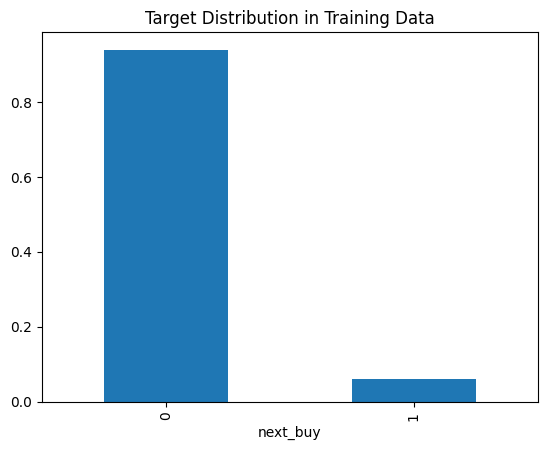

time: 13 s (started: 2025-07-11 20:15:56 +08:00)


In [25]:
train_final['next_buy'].value_counts(normalize=True).sort_index().plot(kind='bar', title='Target Distribution in Training Data')

In [42]:
# # Quick aggregation
# aggregated_df_train = quick_aggregation_pipeline(train_processed)

# # Or use the main function directly
# aggregated_df_train = feature_aggregator_v5_rfm_optimized(train_processed)

# # Check results
# print(f"Final shape: {aggregated_df_train.shape}")
# print(f"Features: {list(aggregated_df_train.columns)}")

# # Ready for modeling!
# feature_cols = [col for col in aggregated_df_train.columns
#                if col not in ['MemberID', 'TransactionID', 'next_buy_max']]
# X = aggregated_df_train[feature_cols]
# y = aggregated_df_train['next_buy_max'] if 'next_buy_max' in aggregated_df_train.columns else None


time: 16 ms (started: 2025-07-11 18:27:06 +08:00)


In [ ]:
# # Quick aggregation
# aggregated_df_test = quick_aggregation_pipeline(test_processed)

# # Or use the main function directly
# aggregated_df_test = feature_aggregator_v5_rfm_optimized(test_processed)

# # Check results
# print(f"Final shape: {aggregated_df_test.shape}")
# print(f"Features: {list(aggregated_df_test.columns)}")

# # Ready for modeling!
# feature_cols = [col for col in aggregated_df_test.columns
#                if col not in ['MemberID', 'TransactionID', 'next_buy_max']]
# X = aggregated_df_test[feature_cols]
# y = aggregated_df_test['next_buy_max'] if 'next_buy_max' in aggregated_df_test.columns else None



# Validasi

In [26]:
import pandas as pd
import numpy as np

def high_corr_pairs(df: pd.DataFrame, threshold=0.9, method='pearson', show_abs=True):
    """
    Mencari pasangan kolom dengan korelasi tinggi dalam sebuah DataFrame.

    Args:
        df : pd.DataFrame
            DataFrame berisi data numerik.
        threshold : float
            Ambang batas minimal |korelasi| untuk dianggap "high correlation".
        method : str
            Metode korelasi: 'pearson', 'spearman', atau 'kendall'.
        show_abs : bool
            Jika True, urutkan/ambil korelasi berdasarkan nilai absolutnya.

    Returns:
        pd.DataFrame
            Tabel pasangan kolom dengan korelasi tinggi, beserta nilai korelasi.
    """

    # 1. Hitung korelasi antar kolom numerik
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    corr_matrix = df[numeric_cols].corr(method=method)

    # 2. Dapatkan pasangan unik (tanpa duplikat & tanpa diagonal)
    corr_pairs = (
        corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        .stack()
        .reset_index()
    )
    corr_pairs.columns = ['col1', 'col2', 'correlation']

    # 3. Filter berdasarkan threshold
    if show_abs:
        high_corrs = corr_pairs[abs(corr_pairs['correlation']) >= threshold]
    else:
        high_corrs = corr_pairs[(corr_pairs['correlation'] >= threshold) | (corr_pairs['correlation'] <= -threshold)]

    # 4. Urutkan dari terbesar ke kecil
    high_corrs = high_corrs.reindex(high_corrs['correlation'].abs().sort_values(ascending=False).index).reset_index(drop=True)

    return high_corrs



time: 0 ns (started: 2025-07-11 20:16:09 +08:00)


In [27]:
def get_missing_columns(df1: pd.DataFrame, df2: pd.DataFrame) -> list:
    """
    Returns a list of columns that exist in df1 but not in df2

    Parameters:
        df1 (pd.DataFrame): First DataFrame (reference)
        df2 (pd.DataFrame): Second DataFrame to compare

    Returns:
        list: Columns present in df1 but missing in df2
    """
    cols_df1 = set(df1.columns)
    cols_df2 = set(df2.columns)
    return list(cols_df1 - cols_df2)

time: 0 ns (started: 2025-07-11 20:16:09 +08:00)


In [28]:
def get_object_or_category_columns(df):
    """Return list of columns with dtype object or category"""
    return df.select_dtypes(include=['object', 'category']).columns.tolist()


time: 0 ns (started: 2025-07-11 20:16:09 +08:00)


In [108]:
# --- CONTOH PENGGUNAAN ---
if __name__ == "__main__":
    # Contoh data dummy
    # Deteksi kolom high corr
    corr_table = high_corr_pairs(train_final, threshold=0.7)
    print("Pairs with high correlation (|corr| > 0.7):")
    print(corr_table)


Pairs with high correlation (|corr| > 0.7):
                                   col1                               col2  \
0                         RFM_Frequency                  transaction_count   
1     categories_purchased_cumsum_total                  transaction_count   
2                         RFM_Frequency  categories_purchased_cumsum_total   
3     categories_purchased_cumsum_total     product_exploration_rate_total   
4        product_exploration_rate_total                  transaction_count   
...                                 ...                                ...   
1190      eldest_age_at_transaction_std      predictive_recency_score_mean   
1191            approaching_weaning_max          approaching_weaning_total   
1192                has_unusual_gap_std       predictive_recency_score_min   
1193                has_unusual_gap_std      purchase_frequency_trend_mean   
1194            is_holiday_season_total                     total_quantity   

      correlation  

In [29]:
import pandas as pd

def print_nan_stats(df, show_sample=False, sample_size=3):
    """
    Print NaN statistics for each column in a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame to analyze
    show_sample : bool (default=False)
        Whether to show examples of NaN values
    sample_size : int (default=3)
        Number of sample rows to show if show_sample=True

    Returns:
    --------
    None (prints results to console)
    """
    # Calculate NaN statistics
    nan_counts = df.isna().sum()
    nan_percent = df.isna().mean() * 100
    total_nans = nan_counts.sum()

    # Print summary
    print(f"\nNaN Analysis for DataFrame with {len(df)} rows and {len(df.columns)} columns")
    print(f"Total NaN values: {total_nans}")
    print(f"Columns with NaN values: {sum(nan_counts > 0)}/{len(df.columns)}")

    # Print detailed column info
    print("\nColumn-wise NaN statistics:")
    print("{:<30} {:<10} {:<10} {:<15}".format(
        'Column', 'NaN Count', 'NaN %', 'Dtype'))
    print("-" * 65)

    for col in df.columns:
        if nan_counts[col] > 0:
            print("{:<30} {:<10} {:<10.2f}% {:<15}".format(
                col,
                nan_counts[col],
                nan_percent[col],
                str(df[col].dtype)))

            # Show sample rows with NaN if requested
            if show_sample:
                nan_rows = df[df[col].isna()]
                if not nan_rows.empty:
                    print("   Sample rows with NaN:")
                    for idx in nan_rows.head(sample_size).index:
                        print(f"   - Index {idx}: ", end="")
                        # Show some non-NaN values from the same row
                        sample_values = df.loc[idx].dropna().head(3)
                        print(", ".join(f"{k}={v}" for k,v in sample_values.items()))
                    print()

    # Print columns without NaN values
    no_nan_cols = [col for col in df.columns if nan_counts[col] == 0]
    if no_nan_cols:
        print("\nColumns with no NaN values:")
        print(", ".join(no_nan_cols))

time: 0 ns (started: 2025-07-11 20:16:09 +08:00)


In [30]:
import pandas as pd
import numpy as np

def delete_NaN_cols(df, threshold=0.001, keep_cols=None, verbose=True):
    """
    Delete columns with NaN values based on specified threshold.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame
    threshold : float (default=1.0)
        Delete columns with NaN ratio >= this threshold (0.0-1.0)
    keep_cols : list (optional)
        List of columns to always keep, even if they contain NaNs
    verbose : bool (default=True)
        Whether to print information about deleted columns

    Returns:
    --------
    pandas.DataFrame
        DataFrame with columns removed according to criteria
    """
    # Make a copy to avoid modifying original DataFrame
    df = df.copy()

    # Validate threshold
    if not 0 <= threshold <= 1:
        raise ValueError("Threshold must be between 0 and 1")

    # Calculate NaN ratio for each column
    nan_ratios = df.isna().mean()

    # Identify columns to drop (above threshold and not in keep_cols)
    cols_to_drop = [col for col in df.columns
                   if nan_ratios[col] >= threshold
                   and (keep_cols is None or col not in keep_cols)]

    if verbose:
        print(f"Found {len(cols_to_drop)} columns with ≥{threshold:.0%} NaN values")
        if cols_to_drop:
            print("Columns to be dropped:")
            for col in cols_to_drop:
                print(f"- {col}: {nan_ratios[col]:.1%} NaN")

    # Drop the columns
    df = df.drop(columns=cols_to_drop)

    return df

time: 0 ns (started: 2025-07-11 20:16:09 +08:00)


In [41]:
print_nan_stats(train_final, show_sample=True, sample_size=5)
print_nan_stats(test_final, show_sample=True, sample_size=5)


NaN Analysis for DataFrame with 40020 rows and 281 columns
Total NaN values: 0
Columns with NaN values: 0/281

Column-wise NaN statistics:
Column                         NaN Count  NaN %      Dtype          
-----------------------------------------------------------------

Columns with no NaN values:
MemberID, Point_max, Point_mean, Point_min, Point_std, Point_total, Point_trend, RFM_F_Score, RFM_Frequency, RFM_M_Score, RFM_Monetary, RFM_R_Score, RFM_Recency, RFM_Score, RFM_Segment, approaching_toddler_max, approaching_toddler_mean, approaching_toddler_min, approaching_toddler_std, approaching_toddler_total, approaching_toddler_trend, approaching_weaning_max, approaching_weaning_mean, approaching_weaning_min, approaching_weaning_std, approaching_weaning_total, approaching_weaning_trend, avg_price, avg_quantity, avg_spending, basket_size_stability_max, basket_size_stability_mean, basket_size_stability_min, basket_size_stability_std, basket_size_stability_total, basket_size_stability_t

In [40]:
train_final = delete_NaN_cols(train_final, threshold=0.01, keep_cols=['MemberID', 'next_buy'], verbose=True)

Found 1 columns with ≥1% NaN values
Columns to be dropped:
- avg_purchase_interval: 71.5% NaN
time: 125 ms (started: 2025-07-11 20:17:47 +08:00)


In [39]:
test_final = delete_NaN_cols(test_final, threshold=0.01, keep_cols=['MemberID', 'next_buy'], verbose=True)


Found 1 columns with ≥1% NaN values
Columns to be dropped:
- avg_purchase_interval: 60.8% NaN
time: 31 ms (started: 2025-07-11 20:17:42 +08:00)


# Adversarial

## Merge Dulu

In [36]:
# Cek apakah ada duplikasi kolom 'MemberID'
if 'MemberID' in train_final.columns:
    # Hitung berapa banyak kolom bernama 'MemberID'
    n_memberid = sum(train_final.columns == 'MemberID')
    
    if n_memberid > 1:
        print(f"⚠️ Ada {n_memberid} kolom 'MemberID'. Menghapus duplikat...")
        train_final = train_final.loc[:, ~train_final.columns.duplicated(keep='first')]
        print("✅ Kolom duplikat dihapus.")
    else:
        print("ℹ️ Hanya ada 1 kolom 'MemberID'. Tidak ada yang dihapus.")
else:
    print("❌ Kolom 'MemberID' tidak ditemukan di DataFrame.")

ℹ️ Hanya ada 1 kolom 'MemberID'. Tidak ada yang dihapus.
time: 0 ns (started: 2025-07-11 20:17:35 +08:00)


In [38]:
# Cek apakah ada duplikasi kolom 'MemberID'
if 'MemberID' in test_final.columns:
    # Hitung berapa banyak kolom bernama 'MemberID'
    n_memberid = sum(test_final.columns == 'MemberID')
    
    if n_memberid > 1:
        print(f"⚠️ Ada {n_memberid} kolom 'MemberID'. Menghapus duplikat...")
        test_final = test_final.loc[:, ~test_final.columns.duplicated(keep='first')]
        print("✅ Kolom duplikat dihapus.")
    else:
        print("ℹ️ Hanya ada 1 kolom 'MemberID'. Tidak ada yang dihapus.")
else:
    print("❌ Kolom 'MemberID' tidak ditemukan di DataFrame.")

ℹ️ Hanya ada 1 kolom 'MemberID'. Tidak ada yang dihapus.
time: 0 ns (started: 2025-07-11 20:17:39 +08:00)


In [ ]:
# # Merge dulu
# # # Contoh penggabungan data
# train_final = pd.merge(train_final, train_graph_features, on='MemberID', how='left')
# test_final = pd.merge(test_final, test_graph_features, on='MemberID', how='left')

time: 125 ms (started: 2025-07-11 20:18:20 +08:00)


In [42]:
print_nan_stats(train_final, show_sample=True, sample_size=5)


NaN Analysis for DataFrame with 40020 rows and 281 columns
Total NaN values: 0
Columns with NaN values: 0/281

Column-wise NaN statistics:
Column                         NaN Count  NaN %      Dtype          
-----------------------------------------------------------------

Columns with no NaN values:
MemberID, Point_max, Point_mean, Point_min, Point_std, Point_total, Point_trend, RFM_F_Score, RFM_Frequency, RFM_M_Score, RFM_Monetary, RFM_R_Score, RFM_Recency, RFM_Score, RFM_Segment, approaching_toddler_max, approaching_toddler_mean, approaching_toddler_min, approaching_toddler_std, approaching_toddler_total, approaching_toddler_trend, approaching_weaning_max, approaching_weaning_mean, approaching_weaning_min, approaching_weaning_std, approaching_weaning_total, approaching_weaning_trend, avg_price, avg_quantity, avg_spending, basket_size_stability_max, basket_size_stability_mean, basket_size_stability_min, basket_size_stability_std, basket_size_stability_total, basket_size_stability_t

In [109]:
def adversarial_feature_selection(train_df, test_df, threshold=0.6):
    """Gunakan adversarial validation untuk seleksi features dengan LightGBM (fast)"""
    import lightgbm as lgb
    from sklearn.model_selection import cross_val_score, StratifiedKFold

    # Pastikan kolom-kolom di test sama persis urutan dan isinya dengan train sebelum concat
    common_cols = train_df.columns.intersection(test_df.columns).tolist()

    train_copy = train_df[common_cols].copy()
    test_copy = test_df[common_cols].copy()

    train_copy['is_test'] = 0
    test_copy['is_test'] = 1

    combined = pd.concat([train_copy, test_copy], ignore_index=True)

    # Test setiap feature secara individual
    feature_scores = {}

    numeric_cols = combined.select_dtypes(include=['int8','int64', 'float64','float32']).columns.tolist()

    for col in common_cols:
        if col in numeric_cols:
            X_single = combined[[col]]
            y = combined['is_test']

            model = lgb.LGBMClassifier(
                n_estimators=30,
                num_leaves=2,
                max_depth=1,
                random_state=42,
                verbosity=-1
            )

            cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
            scores = cross_val_score(model, X_single, y, cv=cv, scoring='roc_auc')
            feature_scores[col] = scores.mean()


    # Filter features yang tidak terlalu discriminative
    safe_features = [col for col, score in feature_scores.items() if score < threshold]
    risky_features = [col for col, score in feature_scores.items() if score >= threshold]

    print(f"Safe features (AUC < {threshold}): {len(safe_features)}")
    print(f"Risky features (AUC >= {threshold}): {len(risky_features)}")

    if len(risky_features) <= 10:
        print(f"Risky features: {risky_features}")

    return safe_features, risky_features, feature_scores

# Contoh penggunaan
safe_features, risky_features, scores = adversarial_feature_selection(train_final, test_final, threshold=0.75)


Safe features (AUC < 0.75): 290
Risky features (AUC >= 0.75): 0
Risky features: []
time: 42.4 s (started: 2025-07-11 21:04:01 +08:00)


In [99]:
train_final['next_buy']

0        0
1        0
2        0
3        0
4        0
        ..
40015    0
40016    0
40017    1
40018    0
40019    0
Name: next_buy, Length: 40020, dtype: int8

time: 0 ns (started: 2025-07-11 20:57:01 +08:00)


<Axes: title={'center': 'Favorite Product Distribution'}, xlabel='favorite_product'>

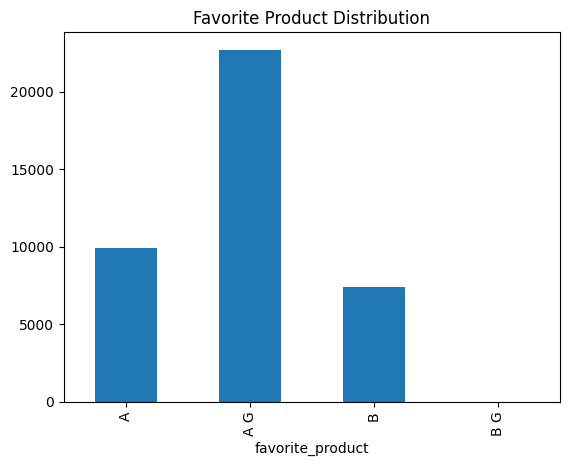

time: 125 ms (started: 2025-07-11 19:02:11 +08:00)


In [78]:
train_final['favorite_product'].value_counts().sort_index().plot(kind='bar', title='Favorite Product Distribution')


# Comphrehensive Analysis

In [100]:
# Prepare data for train-test classifier
def prepare_train_test_data(train_df, test_df):
    """
    Gabungkan train dan test data, buat label untuk membedakan keduanya
    """
    # Pastikan kolom yang sama
    common_cols = list(set(train_df.columns) & set(test_df.columns))
    print(f"Common columns: {len(common_cols)}")

    # Ambil subset kolom yang sama
    train_subset = train_df[common_cols].copy()
    test_subset = test_df[common_cols].copy()

    # Buat label: 0 = train, 1 = test
    train_subset['is_test'] = 0
    test_subset['is_test'] = 1

    # Gabungkan data
    combined_data = pd.concat([train_subset, test_subset], ignore_index=True)

    return combined_data, common_cols

# Prepare data
combined_data, common_cols = prepare_train_test_data(train_final.drop(risky_features,axis=1), test_final.drop(risky_features,axis=1))
print(f"Combined data shape: {combined_data.shape}")
print(f"Train samples: {(combined_data['is_test'] == 0).sum()}")
print(f"Test samples: {(combined_data['is_test'] == 1).sum()}")


Common columns: 286
Combined data shape: (46401, 287)
Train samples: 40020
Test samples: 6381
time: 375 ms (started: 2025-07-11 21:02:21 +08:00)


In [101]:
# Data preprocessing
from sklearn.preprocessing import LabelEncoder
import numpy as np

def preprocess_data(df, target_col='is_test'):
    """
    Preprocessing data untuk modeling
    """
    df_processed = df.copy()

    # Pisahkan features dan target
    X = df_processed.drop(columns=[target_col])
    y = df_processed[target_col]

    # Handle missing values
    print(f"Missing values per column:")
    missing_counts = X.isnull().sum()
    print(missing_counts[missing_counts > 0])

    # Fill missing values
    for col in X.columns:
        if X[col].dtype in ['object', 'category']:
            X[col] = X[col].fillna('missing')
        else:
            X[col] = X[col].fillna(X[col].median())

    # Handle categorical variables
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    print(f"Categorical columns: {len(categorical_cols)}")

    # Label encoding untuk categorical variables
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

    # Handle infinite values
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())

    return X, y, label_encoders

# Preprocess data
X, y, label_encoders = preprocess_data(combined_data)
print(f"Features shape: {X.shape}")
print(f"Target distribution:")
print(y.value_counts(normalize=True))


Missing values per column:
Series([], dtype: int64)
Categorical columns: 1
Features shape: (46401, 286)
Target distribution:
is_test
0    0.862481
1    0.137519
Name: proportion, dtype: float64
time: 1.02 s (started: 2025-07-11 21:02:22 +08:00)


In [102]:
# Train-Test Split untuk evaluasi
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

# Baseline accuracy (majority class)
baseline_accuracy = max(y.value_counts(normalize=True))
print(f"Baseline accuracy (majority class): {baseline_accuracy:.4f}")


Training set: (37120, 286)
Validation set: (9281, 286)
Baseline accuracy (majority class): 0.8625
time: 171 ms (started: 2025-07-11 21:02:23 +08:00)


In [103]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Model 1: Random Forest
print("=" * 50)
print("RANDOM FOREST CLASSIFIER")
print("=" * 50)


rf_model = RandomForestClassifier(
    n_estimators=20,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

# Train model
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_val)
y_pred_proba_rf = rf_model.predict_proba(X_val)[:, 1]

# Evaluate
rf_accuracy = accuracy_score(y_val, y_pred_rf)
rf_auc = roc_auc_score(y_val, y_pred_proba_rf)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Random Forest AUC: {rf_auc:.4f}")
print(f"Improvement over baseline: {rf_accuracy - baseline_accuracy:.4f}")

# Cross-validation
cv_scores_rf = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print(f"CV Accuracy: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")


RANDOM FOREST CLASSIFIER
Random Forest Accuracy: 0.8664
Random Forest AUC: 0.8186
Improvement over baseline: 0.0039
CV Accuracy: 0.8574 (+/- 0.0255)
time: 2.69 s (started: 2025-07-11 21:02:23 +08:00)


In [104]:
# Model 2: Logistic Regression
print("=" * 50)
print("LOGISTIC REGRESSION")
print("=" * 50)

lr_model = LogisticRegression(
    random_state=42,
    max_iter=20
)

# Train model
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_val)
y_pred_proba_lr = lr_model.predict_proba(X_val)[:, 1]

# Evaluate
lr_accuracy = accuracy_score(y_val, y_pred_lr)
lr_auc = roc_auc_score(y_val, y_pred_proba_lr)

print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(f"Logistic Regression AUC: {lr_auc:.4f}")
print(f"Improvement over baseline: {lr_accuracy - baseline_accuracy:.4f}")

# Cross-validation
cv_scores_lr = cross_val_score(lr_model, X, y, cv=5, scoring='accuracy')
print(f"CV Accuracy: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std() * 2:.4f})")


LOGISTIC REGRESSION
Logistic Regression Accuracy: 0.8624
Logistic Regression AUC: 0.5049
Improvement over baseline: -0.0001
CV Accuracy: 0.8595 (+/- 0.0043)
time: 4.92 s (started: 2025-07-11 21:02:26 +08:00)


FEATURE IMPORTANCE ANALYSIS
Top 20 Most Important Features (Random Forest):
                             feature  importance
84     predictive_recency_score_mean    0.131757
210                network_stability    0.095110
271              has_unusual_gap_std    0.080991
236                  avg_edge_weight    0.072908
232                network_influence    0.067250
131                  max_edge_weight    0.048565
261                total_edge_weight    0.028295
238               connection_quality    0.026741
16              has_unusual_gap_mean    0.026298
138     predictive_recency_score_min    0.024787
215              has_unusual_gap_max    0.021074
113  youngest_age_at_transaction_std    0.019600
219            has_unusual_gap_trend    0.018877
134                      RFM_M_Score    0.016302
256                      RFM_Recency    0.014559
32                       Point_total    0.014356
71                 transaction_count    0.013738
127                   total_spending    0.

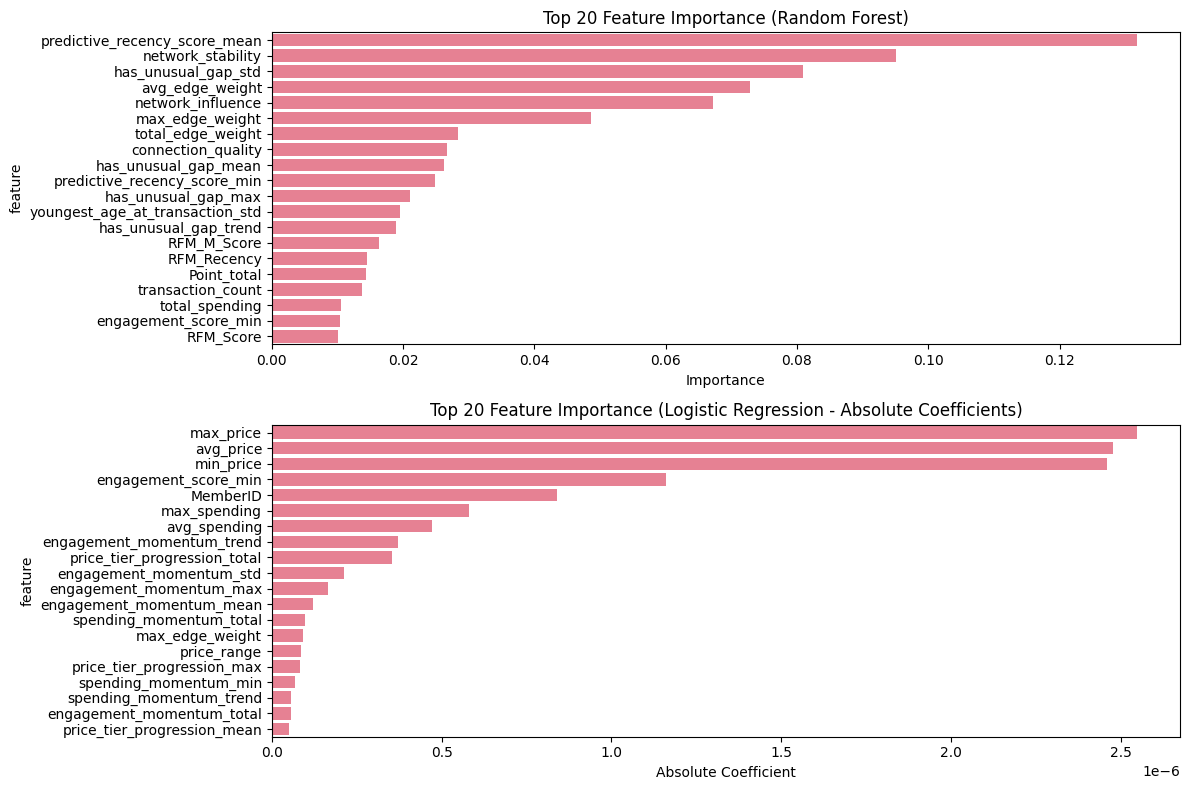

time: 719 ms (started: 2025-07-11 21:02:31 +08:00)


In [105]:
# Feature Importance Analysis
print("=" * 50)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

# Random Forest Feature Importance
feature_importance_rf = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features (Random Forest):")
print(feature_importance_rf.head(20))

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
sns.barplot(data=feature_importance_rf.head(20), x='importance', y='feature')
plt.title('Top 20 Feature Importance (Random Forest)')
plt.xlabel('Importance')

# Logistic Regression Coefficients
feature_importance_lr = pd.DataFrame({
    'feature': X.columns,
    'coef_abs': np.abs(lr_model.coef_[0])
}).sort_values('coef_abs', ascending=False)

plt.subplot(2, 1, 2)
sns.barplot(data=feature_importance_lr.head(20), x='coef_abs', y='feature')
plt.title('Top 20 Feature Importance (Logistic Regression - Absolute Coefficients)')
plt.xlabel('Absolute Coefficient')

plt.tight_layout()
plt.show()


In [106]:
# Detailed Classification Report
print("=" * 50)
print("DETAILED RESULTS")
print("=" * 50)

print("Random Forest Classification Report:")
print(classification_report(y_val, y_pred_rf))

print("\nLogistic Regression Classification Report:")
print(classification_report(y_val, y_pred_lr))

# Summary
print("=" * 50)
print("SUMMARY")
print("=" * 50)

results_summary = pd.DataFrame({
    'Model': ['Baseline', 'Random Forest', 'Logistic Regression'],
    'Accuracy': [baseline_accuracy, rf_accuracy, lr_accuracy],
    'AUC': [0.5, rf_auc, lr_auc],
    'Improvement': [0, rf_accuracy - baseline_accuracy, lr_accuracy - baseline_accuracy]
})

print(results_summary)

# Interpretation
print("\n" + "=" * 50)
print("INTERPRETATION")
print("=" * 50)

threshold = 0.1  # 10% improvement threshold

if max(rf_accuracy, lr_accuracy) - baseline_accuracy > threshold:
    print("🚨 SIGNIFICANT DISTRIBUTION SHIFT DETECTED!")
    print(f"Best model accuracy: {max(rf_accuracy, lr_accuracy):.4f}")
    print(f"Improvement over baseline: {max(rf_accuracy, lr_accuracy) - baseline_accuracy:.4f}")
    print("\nThis suggests that train and test distributions are significantly different.")
    print("Consider:")
    print("- Feature engineering to make distributions more similar")
    print("- Domain adaptation techniques")
    print("- Collecting more representative data")
    print("- Using robust models that handle distribution shift")
else:
    print("✅ NO SIGNIFICANT DISTRIBUTION SHIFT")
    print(f"Best model accuracy: {max(rf_accuracy, lr_accuracy):.4f}")
    print(f"Improvement over baseline: {max(rf_accuracy, lr_accuracy) - baseline_accuracy:.4f}")
    print("\nTrain and test distributions appear to be similar.")


DETAILED RESULTS
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      8005
           1       0.97      0.03      0.06      1276

    accuracy                           0.87      9281
   macro avg       0.92      0.51      0.49      9281
weighted avg       0.88      0.87      0.81      9281


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      8005
           1       0.00      0.00      0.00      1276

    accuracy                           0.86      9281
   macro avg       0.43      0.50      0.46      9281
weighted avg       0.74      0.86      0.80      9281

SUMMARY
                 Model  Accuracy       AUC  Improvement
0             Baseline  0.862481  0.500000     0.000000
1        Random Forest  0.866394  0.818634     0.003912
2  Logistic Regression  0.862407  0.504923    -0.000074

INTERPRETATION


In [107]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def plot_feature_distributions(train_df, test_df, feature_importance_df, top_n=25, figsize_per_plot=(4, 3)):
    """
    Plot distribution comparison between train and test for top features
    """

    # Get top features
    top_features = feature_importance_df.head(top_n)['feature'].tolist()

    # Filter features that exist in both datasets
    available_features = []
    for feature in top_features:
        if feature in train_df.columns and feature in test_df.columns:
            available_features.append(feature)
        else:
            print(f"[WARNING] Feature '{feature}' not found in both datasets")

    if not available_features:
        print("[ERROR] No common features found!")
        return

    print(f"[INFO] Plotting {len(available_features)} features...")

    # Calculate grid dimensions
    n_features = len(available_features)
    n_cols = 5
    n_rows = (n_features + n_cols - 1) // n_cols

    # Create figure with explicit backend
    plt.style.use('default')  # Reset style
    fig, axes = plt.subplots(n_rows, n_cols,
                            figsize=(figsize_per_plot[0] * n_cols, figsize_per_plot[1] * n_rows),
                            facecolor='white')

    # Handle single subplot case
    if n_features == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.reshape(1, -1)

    axes = axes.flatten()

    # Plot each feature
    for i, feature in enumerate(available_features):
        try:
            # Get data
            train_values = train_df[feature].dropna()
            test_values = test_df[feature].dropna()

            if len(train_values) == 0 or len(test_values) == 0:
                axes[i].text(0.5, 0.5, f'No data\nfor {feature}',
                           ha='center', va='center', transform=axes[i].transAxes)
                axes[i].set_title(f'{feature}')
                continue

            # Calculate bins for consistent comparison
            all_values = np.concatenate([train_values, test_values])
            bins = np.histogram_bin_edges(all_values, bins=30)

            # Plot histograms
            axes[i].hist(train_values, alpha=0.6, label='Train', bins=bins,
                        density=True, color='blue', edgecolor='black', linewidth=0.5)
            axes[i].hist(test_values, alpha=0.6, label='Test', bins=bins,
                        density=True, color='red', edgecolor='black', linewidth=0.5)

            # Formatting
            axes[i].set_title(f'{feature}', fontsize=10, pad=10)
            axes[i].legend(fontsize=8)
            axes[i].set_xlabel('Value', fontsize=8)
            axes[i].set_ylabel('Density', fontsize=8)
            axes[i].tick_params(labelsize=7)
            axes[i].grid(True, alpha=0.3)

            # Add statistics text
            train_mean = train_values.mean()
            test_mean = test_values.mean()
            diff = abs(train_mean - test_mean)

            stats_text = f'Δμ: {diff:.3f}'
            axes[i].text(0.02, 0.98, stats_text, transform=axes[i].transAxes,
                        fontsize=7, verticalalignment='top',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

        except Exception as e:
            print(f"[ERROR] Failed to plot {feature}: {str(e)}")
            axes[i].text(0.5, 0.5, f'Error plotting\n{feature}',
                       ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{feature}')

    # Hide unused subplots
    for j in range(len(available_features), len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout(pad=2.0)

    # Force display
    plt.show(block=False)
    plt.draw()

    return fig, available_features

def statistical_comparison(train_df, test_df, features, detailed=True):
    """
    Detailed statistical comparison of features
    """

    print("=" * 70)
    print("FEATURE DISTRIBUTION ANALYSIS")
    print("=" * 70)

    comparison_results = []

    for i, feature in enumerate(features, 1):
        if feature not in train_df.columns or feature not in test_df.columns:
            print(f"\n{i:2d}. {feature}: MISSING IN ONE DATASET")
            continue

        train_vals = train_df[feature].dropna()
        test_vals = test_df[feature].dropna()

        if len(train_vals) == 0 or len(test_vals) == 0:
            print(f"\n{i:2d}. {feature}: NO DATA")
            continue

        # Basic statistics
        train_mean, train_std = train_vals.mean(), train_vals.std()
        test_mean, test_std = test_vals.mean(), test_vals.std()
        mean_diff = abs(train_mean - test_mean)
        std_diff = abs(train_std - test_std)

        # Statistical tests
        try:
            # Kolmogorov-Smirnov test
            ks_stat, ks_pval = stats.ks_2samp(train_vals, test_vals)

            # Mann-Whitney U test (non-parametric)
            mw_stat, mw_pval = stats.mannwhitneyu(train_vals, test_vals, alternative='two-sided')

            # Effect size (Cohen's d)
            pooled_std = np.sqrt(((len(train_vals) - 1) * train_std**2 +
                                 (len(test_vals) - 1) * test_std**2) /
                                (len(train_vals) + len(test_vals) - 2))
            cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0

        except Exception as e:
            ks_stat = ks_pval = mw_stat = mw_pval = cohens_d = np.nan

        # Risk assessment
        risk_level = "LOW"
        if ks_pval < 0.01 or cohens_d > 0.8:
            risk_level = "HIGH"
        elif ks_pval < 0.05 or cohens_d > 0.5:
            risk_level = "MEDIUM"

        comparison_results.append({
            'feature': feature,
            'train_mean': train_mean,
            'test_mean': test_mean,
            'mean_diff': mean_diff,
            'ks_pval': ks_pval,
            'cohens_d': cohens_d,
            'risk_level': risk_level
        })

        if detailed:
            print(f"\n{i:2d}. {feature}:")
            print(f"    Train - Mean: {train_mean:8.4f}, Std: {train_std:8.4f}")
            print(f"    Test  - Mean: {test_mean:8.4f}, Std: {test_std:8.4f}")
            print(f"    Differences - Mean: {mean_diff:8.4f}, Std: {std_diff:8.4f}")
            print(f"    KS p-value: {ks_pval:8.4f}, Cohen's d: {cohens_d:8.4f}")
            print(f"    Risk Level: {risk_level}")

    # Summary
    print("\n" + "=" * 70)
    print("RISK SUMMARY")
    print("=" * 70)

    risk_counts = {'LOW': 0, 'MEDIUM': 0, 'HIGH': 0}
    for result in comparison_results:
        risk_counts[result['risk_level']] += 1

    total_features = len(comparison_results)
    print(f"Total features analyzed: {total_features}")
    print(f"LOW risk (similar distributions):    {risk_counts['LOW']:3d} ({risk_counts['LOW']/total_features*100:.1f}%)")
    print(f"MEDIUM risk (moderate differences):  {risk_counts['MEDIUM']:3d} ({risk_counts['MEDIUM']/total_features*100:.1f}%)")
    print(f"HIGH risk (significant differences): {risk_counts['HIGH']:3d} ({risk_counts['HIGH']/total_features*100:.1f}%)")

    # High risk features
    high_risk_features = [r['feature'] for r in comparison_results if r['risk_level'] == 'HIGH']
    if high_risk_features:
        print(f"\nHIGH RISK FEATURES:")
        for feature in high_risk_features:
            print(f"  - {feature}")

    return comparison_results

# Usage function
def analyze_feature_distributions(train_df, test_df, feature_importance_df, top_n=10):
    """
    Complete analysis: plot distributions and statistical comparison
    """

    print("[INFO] Starting feature distribution analysis...")

    # Plot distributions
    try:
        fig, available_features = plot_feature_distributions(
            train_df, test_df, feature_importance_df, top_n=top_n
        )
        print(f"[SUCCESS] Plotted distributions for {len(available_features)} features")
    except Exception as e:
        print(f"[ERROR] Failed to create plots: {str(e)}")
        available_features = feature_importance_df.head(top_n)['feature'].tolist()

    # Statistical comparison
    try:
        comparison_results = statistical_comparison(
            train_df, test_df, available_features[:10], detailed=True  # Top 10 for detailed analysis
        )
        print(f"[SUCCESS] Completed statistical analysis")
    except Exception as e:
        print(f"[ERROR] Failed statistical comparison: {str(e)}")
        comparison_results = None

    return comparison_results



time: 0 ns (started: 2025-07-11 21:02:32 +08:00)


# Risky Featues

In [75]:
risky_features

['engagement_score_max',
 'engagement_score_mean',
 'engagement_score_std',
 'engagement_score_total',
 'engagement_score_trend',
 'predictive_recency_score_max',
 'predictive_recency_score_std',
 'predictive_recency_score_total',
 'predictive_recency_score_trend']

time: 15 ms (started: 2025-07-11 20:27:04 +08:00)


[INFO] Starting feature distribution analysis...
[INFO] Plotting 20 features...


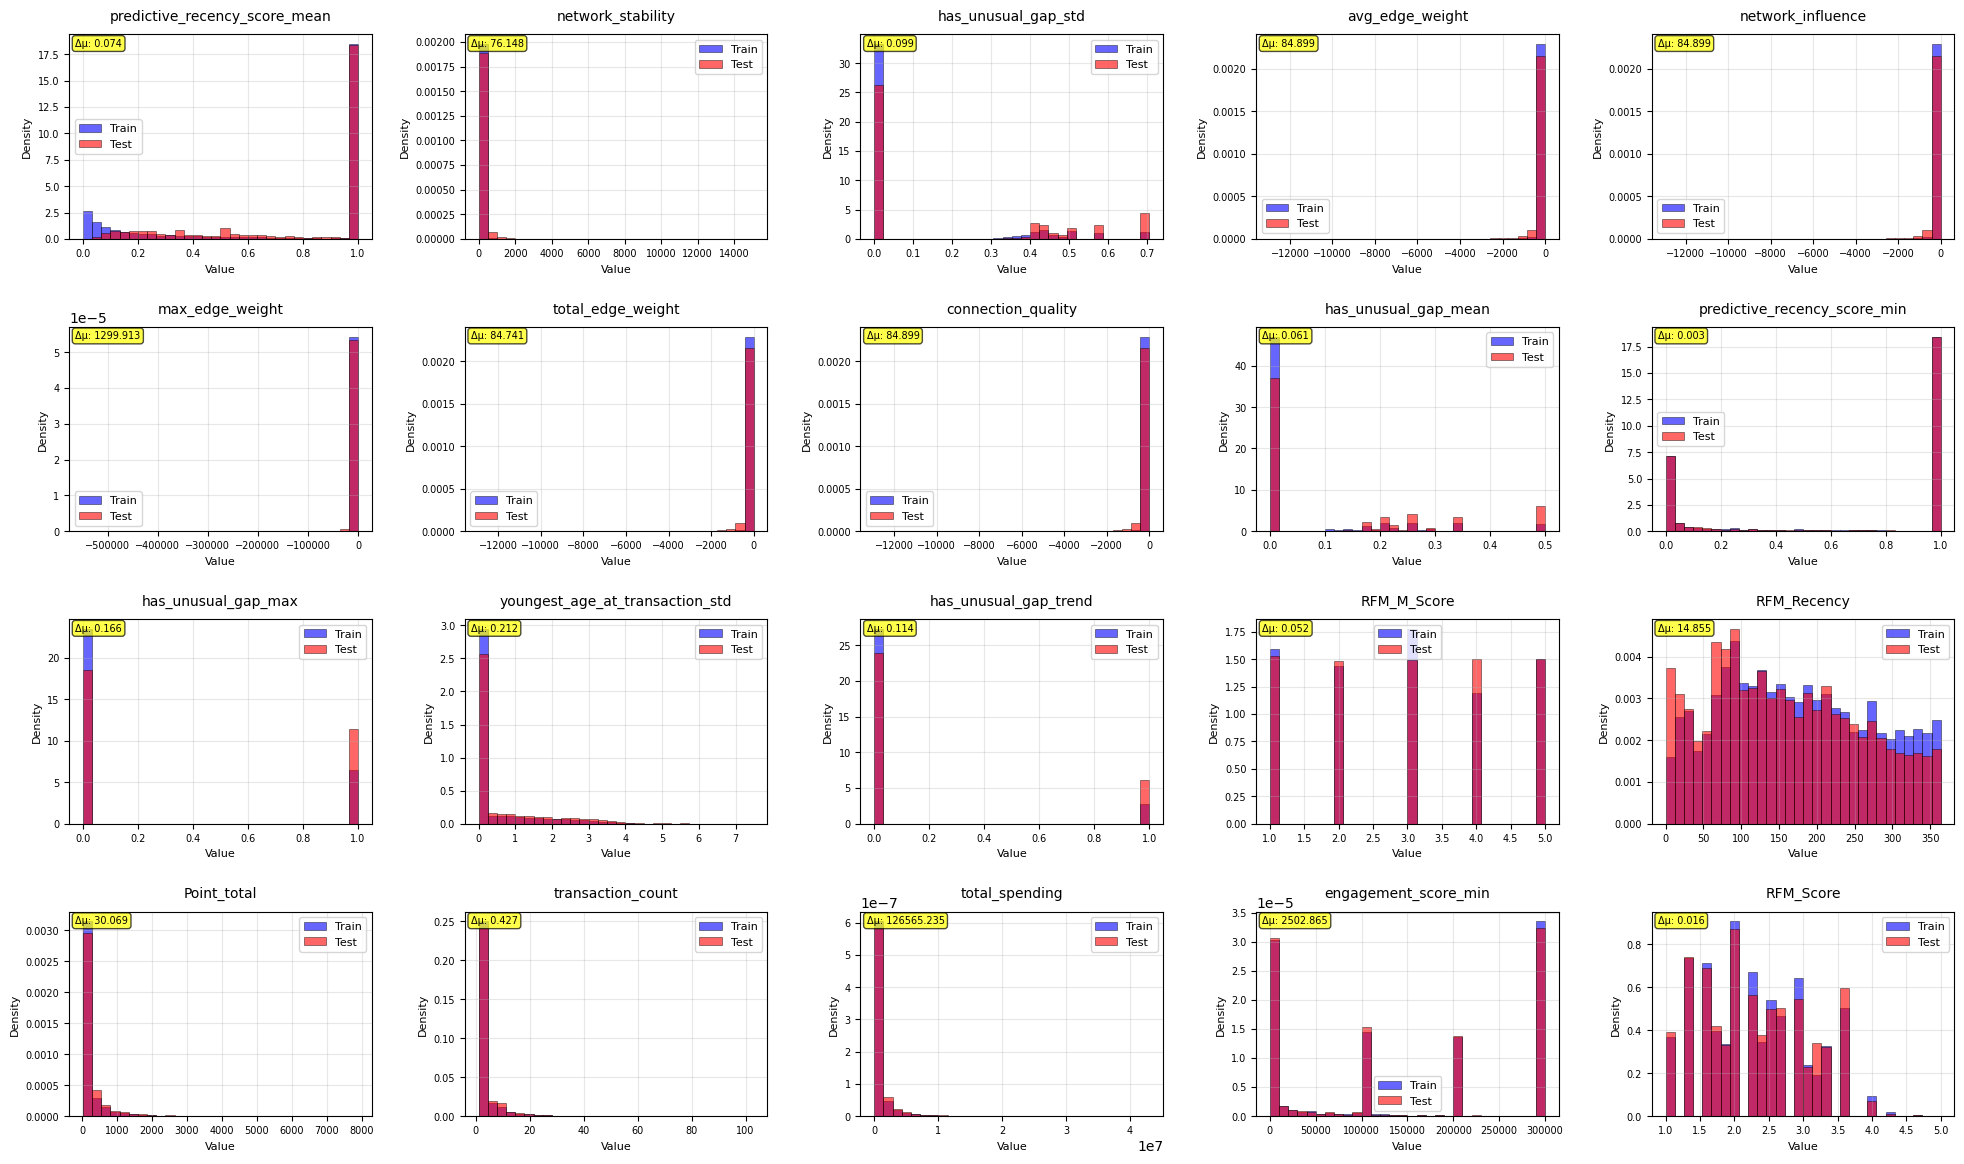

[SUCCESS] Plotted distributions for 20 features
FEATURE DISTRIBUTION ANALYSIS

 1. predictive_recency_score_mean:
    Train - Mean:   0.6911, Std:   0.4127
    Test  - Mean:   0.7651, Std:   0.3281
    Differences - Mean:   0.0739, Std:   0.0846
    KS p-value:   0.0000, Cohen's d:   0.1839
    Risk Level: HIGH

 2. network_stability:
    Train - Mean:  24.8420, Std: 194.5808
    Test  - Mean: 100.9898, Std: 432.3353
    Differences - Mean:  76.1478, Std: 237.7545
    KS p-value:   0.0000, Cohen's d:   0.3152
    Risk Level: HIGH

 3. has_unusual_gap_std:
    Train - Mean:   0.1051, Std:   0.2064
    Test  - Mean:   0.2041, Std:   0.2697
    Differences - Mean:   0.0989, Std:   0.0633
    KS p-value:   0.0000, Cohen's d:   0.4576
    Risk Level: HIGH

 4. avg_edge_weight:
    Train - Mean: -29.5367, Std: 200.7796
    Test  - Mean: -114.4360, Std: 453.8026
    Differences - Mean:  84.8992, Std: 253.0230
    KS p-value:   0.0000, Cohen's d:   0.3380
    Risk Level: HIGH

 5. network_infl

<Figure size 640x480 with 0 Axes>

time: 4.3 s (started: 2025-07-11 21:02:59 +08:00)


In [108]:
# USAGE:
comparison_results = analyze_feature_distributions(train_final.drop(risky_features,axis=1), test_final.drop(risky_features,axis=1), feature_importance_rf, top_n=20)


# Some chunk

# Apalah in

In [81]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import balanced_accuracy_score
import numpy as np
import pandas as pd

# Assume 'train_final' is your DataFrame
# Split feature and target
X = train_final.drop(['next_buy', 'MemberID'], axis=1)
y = train_final['next_buy']

# Drop risky features
X = X.drop(risky_features, axis=1)

# Encode categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Split data into training and hold-out validation set
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Define XGBoost model
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation scores on training set
cv_scores = cross_val_score(
    model,
    X_train,
    y_train,
    cv=cv,
    scoring='balanced_accuracy',
    n_jobs=-1
)

# Print cross-validation results
print("=== Cross-Validation Balanced Accuracy ===")
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i}: {score:.4f}")
print(f"Mean Balanced Accuracy: {np.mean(cv_scores):.4f}")
print(f"Std Dev: {np.std(cv_scores):.4f}")

# Train final model on full training set
model.fit(X_train, y_train)

# Evaluate on hold-out validation set
y_pred_valid = model.predict(X_valid)
bal_acc_valid = balanced_accuracy_score(y_valid, y_pred_valid)
print(f"\nBalanced Accuracy on Hold-out Validation: {bal_acc_valid:.4f}")


=== Cross-Validation Balanced Accuracy ===
Fold 1: 0.7401
Fold 2: 0.7189
Fold 3: 0.6981
Fold 4: 0.7220
Fold 5: 0.7374
Mean Balanced Accuracy: 0.7233
Std Dev: 0.0151

Balanced Accuracy on Hold-out Validation: 0.7081
time: 31.7 s (started: 2025-07-11 20:30:54 +08:00)


                           feature  importance
0                        RFM_Score    0.144694
1          engagement_momentum_max    0.092655
2        engagement_momentum_total    0.065292
3    predictive_recency_score_mean    0.043508
4                      RFM_Recency    0.041228
5                        Point_max    0.017330
6                      RFM_Segment    0.016154
7              frequency_per_month    0.014859
8                      RFM_R_Score    0.014026
9                       Point_mean    0.013758
10    predictive_recency_score_max    0.011392
11           engagement_score_mean    0.008550
12   eldest_age_at_transaction_std    0.008184
13   purchase_time_consistency_max    0.007891
14         engagement_momentum_std    0.007350
15    predictive_recency_score_std    0.006385
16  predictive_recency_score_trend    0.006364
17    predictive_recency_score_min    0.006250
18      youngest_is_preschool_mean    0.006018
19      premium_product_ratio_mean    0.005307


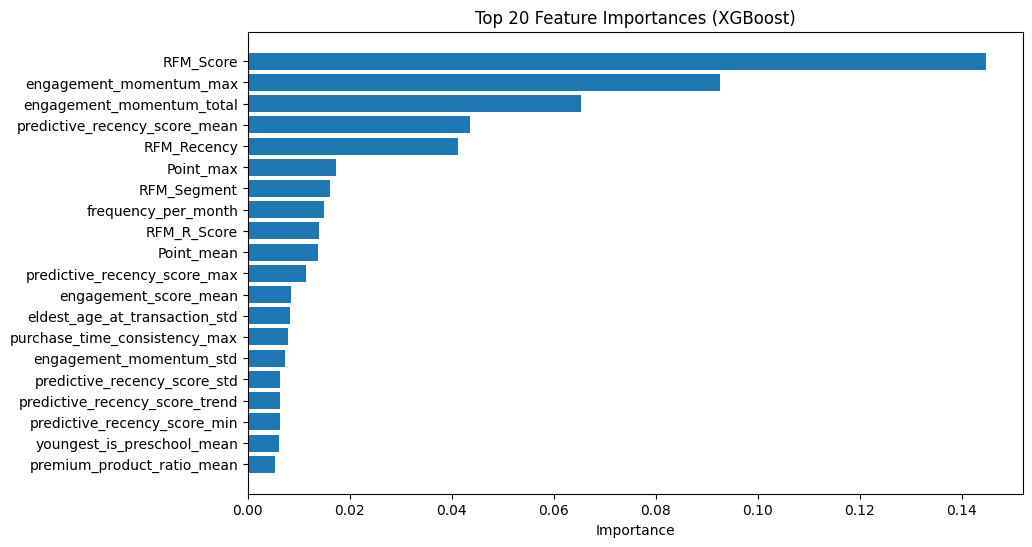

time: 203 ms (started: 2025-07-11 20:28:31 +08:00)


In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# Mendapatkan feature importance
feature_importance = model.feature_importances_
features = X_train.columns

# Buat DataFrame
fi_df = pd.DataFrame({'feature': features, 'importance': feature_importance})
fi_df = fi_df.sort_values('importance', ascending=False).reset_index(drop=True)

# Tampilkan top 20
print(fi_df.head(20))

# Plot
plt.figure(figsize=(10,6))
plt.barh(fi_df['feature'][:20][::-1], fi_df['importance'][:20][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances (XGBoost)')
plt.show()


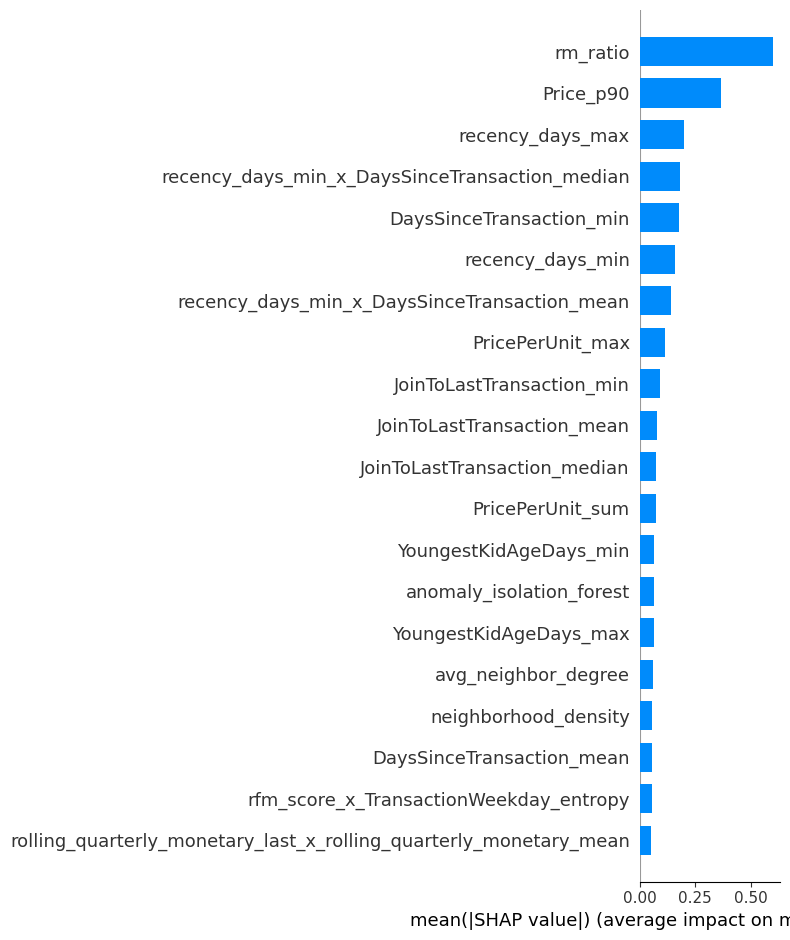

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)

shap.summary_plot(shap_values, X_valid, plot_type="bar", max_display=20)


In [ ]:
fi_df

,feature,importance
0,monthly_monetary_velocity_max,0.254458
1,recency_days_min,0.115081
2,recency_days_max,0.052671
3,DaysSinceTransaction_min,0.032548
4,recency_days_min_x_DaysSinceTransaction_mean,0.030452
...,...,...
439,rolling_monthly_recency_last,0.000000
440,rolling_monthly_recency_median,0.000000
441,Price_median,0.000000
442,Price_min,0.000000


In [ ]:
# 1. Ambil top 20 fitur dari feature importance
top20_features = fi_df['feature'].iloc[:30].tolist()

# 2. Subset data
X_train_top20 = X_train[top20_features]
X_valid_top20 = X_valid[top20_features]

# 3. Model
from xgboost import XGBClassifier
model_top20 = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model_top20.fit(X_train_top20, y_train)

# 4. Evaluasi
from sklearn.metrics import balanced_accuracy_score
y_pred = model_top20.predict(X_valid_top20)
print("Balanced Accuracy:", balanced_accuracy_score(y_valid, y_pred))


Balanced Accuracy: 0.7283647344681075


In [85]:
import pandas as pd

def check_object_category_counts(df):
    """
    Menampilkan value_counts() untuk setiap kolom bertipe object atau category dalam DataFrame.
    """
    obj_cat_cols = df.select_dtypes(include=['object', 'category']).columns

    if len(obj_cat_cols) == 0:
        print("Tidak ada kolom dengan tipe object atau category.")
        return
    
    for col in obj_cat_cols:
        print(f"\n=== Kolom: {col} ===")
        print(df[col].value_counts(dropna=False))
# Contoh penggunaan
check_object_category_counts(train_final)


=== Kolom: MemberID ===
MemberID
00010c8a563eb5555709c8ae3120ba2e    1
257d2a3f5d0647032d738815c34c9456    1
2567c7d54b91021f681c4d67697590e4    1
256d817bac3ef09405501a94eefd1954    1
25743e8c05be49b0d94cfc67e968a714    1
                                   ..
8acb3944c58f0233b90b5f660a439d76    1
8acc095a04a2f91bbe497c1d5abf2b33    1
8ad085c4c734d8ec435a79267007d23c    1
8ad4db638e8c840b9d34135c466a32bc    1
fff4f0fdeb6c25ffe024006d4a48abfe    1
Name: count, Length: 40020, dtype: int64

=== Kolom: RFM_Segment ===
RFM_Segment
At_Risk                23860
Potential_Loyalists     8798
Loyal_Customers         7203
Champions                159
Name: count, dtype: int64

=== Kolom: favorite_category ===
favorite_category
A    32636
B     7384
Name: count, dtype: int64

=== Kolom: favorite_product ===
favorite_product
A G    22700
A       9926
B       7386
B G        8
Name: count, dtype: int64
time: 63 ms (started: 2025-07-11 20:33:55 +08:00)


In [86]:
rfm_segment_mapping = {
    'At_Risk': 0,
    'Potential_Loyalists': 1,
    'Loyal_Customers': 2,
    'Champions': 3
}

favorite_category_mapping = {
    'A': 0,
    'B': 1
}

favorite_product_mapping = {
    'A G': 0,
    'A': 1,
    'B': 2,
    'B G': 3
}
train_final['RFM_Segment'] = train_final['RFM_Segment'].map(rfm_segment_mapping)
train_final['favorite_category'] = train_final['favorite_category'].map(favorite_category_mapping)
train_final['favorite_product'] = train_final['favorite_product'].map(favorite_product_mapping)

test_final['RFM_Segment'] = test_final['RFM_Segment'].map(rfm_segment_mapping)
test_final['favorite_category'] = test_final['favorite_category'].map(favorite_category_mapping)
test_final['favorite_product'] = test_final['favorite_product'].map(favorite_product_mapping)

time: 31 ms (started: 2025-07-11 20:35:37 +08:00)


In [92]:
train_final['favorite_product']

0        2
1        0
2        0
3        1
4        0
        ..
40015    1
40016    1
40017    0
40018    0
40019    0
Name: favorite_product, Length: 40020, dtype: int64

time: 0 ns (started: 2025-07-11 20:49:37 +08:00)


In [87]:
train_final.to_parquet('train_final.parquet', index=False)
test_final.to_parquet('test_final.parquet', index=False)

time: 844 ms (started: 2025-07-11 20:35:47 +08:00)


In [89]:
train_final.dtypes.to_dict(), test_final.dtypes.to_dict()

({'MemberID': dtype('O'),
  'Point_max': dtype('int8'),
  'Point_mean': dtype('float64'),
  'Point_min': dtype('int8'),
  'Point_std': dtype('float64'),
  'Point_total': dtype('int64'),
  'Point_trend': dtype('int8'),
  'RFM_F_Score': dtype('int64'),
  'RFM_Frequency': dtype('int64'),
  'RFM_M_Score': dtype('int64'),
  'RFM_Monetary': dtype('float64'),
  'RFM_R_Score': dtype('int64'),
  'RFM_Recency': dtype('int64'),
  'RFM_Score': dtype('float64'),
  'RFM_Segment': dtype('int64'),
  'approaching_toddler_max': dtype('int8'),
  'approaching_toddler_mean': dtype('float64'),
  'approaching_toddler_min': dtype('int8'),
  'approaching_toddler_std': dtype('float64'),
  'approaching_toddler_total': dtype('int8'),
  'approaching_toddler_trend': dtype('int8'),
  'approaching_weaning_max': dtype('int8'),
  'approaching_weaning_mean': dtype('float64'),
  'approaching_weaning_min': dtype('int8'),
  'approaching_weaning_std': dtype('float64'),
  'approaching_weaning_total': dtype('int8'),
  'approa

time: 31 ms (started: 2025-07-11 20:36:22 +08:00)


# EDA

In [97]:
"""
Comprehensive EDA Script with Full Logging and Error Handling
============================================================

Author: AI Assistant
Purpose: Complete Exploratory Data Analysis for any DataFrame
Features: Full logging, error handling, visualization, statistical analysis
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import logging
from typing import Dict, List, Tuple, Any, Optional
import os
from scipy import stats
from scipy.stats import chi2_contingency
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Suppress warnings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

class ComprehensiveEDA:
    """
    Comprehensive Exploratory Data Analysis with full logging and error handling
    """
    
    def __init__(self, log_level=logging.INFO):
        """Initialize EDA with logging setup"""
        self.setup_logging(log_level)
        self.results = {}
        self.plots_created = []
        
    def setup_logging(self, log_level):
        """Setup comprehensive logging"""
        # Create logs directory if not exists
        os.makedirs('eda_logs', exist_ok=True)
        
        # Setup logging configuration
        log_filename = f"eda_logs/eda_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
        
        logging.basicConfig(
            level=log_level,
            format='%(asctime)s - %(levelname)s - %(funcName)s:%(lineno)d - %(message)s',
            handlers=[
                logging.FileHandler(log_filename),
                logging.StreamHandler()
            ]
        )
        
        self.logger = logging.getLogger(__name__)
        self.logger.info("="*80)
        self.logger.info("COMPREHENSIVE EDA SESSION STARTED")
        self.logger.info("="*80)
    
    def analyze_dataframe(self, df: pd.DataFrame) -> Dict[str, Any]:
        """
        Main function to perform comprehensive EDA
        
        Args:
            df: Input DataFrame
            
        Returns:
            Dictionary containing all analysis results
        """
        try:
            self.logger.info(f"Starting comprehensive EDA for DataFrame with shape: {df.shape}")
            
            # 1. Basic Information
            self.logger.info("Step 1: Analyzing basic information...")
            basic_info = self._analyze_basic_info(df)
            
            # 2. Data Quality Assessment
            self.logger.info("Step 2: Assessing data quality...")
            data_quality = self._analyze_data_quality(df)
            
            # 3. Numerical Analysis
            self.logger.info("Step 3: Analyzing numerical columns...")
            numerical_analysis = self._analyze_numerical_columns(df)
            
            # 4. Categorical Analysis
            self.logger.info("Step 4: Analyzing categorical columns...")
            categorical_analysis = self._analyze_categorical_columns(df)
            
            # 5. Datetime Analysis
            self.logger.info("Step 5: Analyzing datetime columns...")
            datetime_analysis = self._analyze_datetime_columns(df)
            
            # 6. Correlation Analysis
            self.logger.info("Step 6: Performing correlation analysis...")
            correlation_analysis = self._analyze_correlations(df)
            
            # 7. Outlier Detection
            self.logger.info("Step 7: Detecting outliers...")
            outlier_analysis = self._detect_outliers(df)
            
            # 8. Distribution Analysis
            self.logger.info("Step 8: Analyzing distributions...")
            distribution_analysis = self._analyze_distributions(df)
            
            # 9. Create Visualizations
            self.logger.info("Step 9: Creating visualizations...")
            self._create_visualizations(df)
            
            # 10. Generate Summary Report
            self.logger.info("Step 10: Generating summary report...")
            summary_report = self._generate_summary_report(df)
            
            # Compile all results
            self.results = {
                'basic_info': basic_info,
                'data_quality': data_quality,
                'numerical_analysis': numerical_analysis,
                'categorical_analysis': categorical_analysis,
                'datetime_analysis': datetime_analysis,
                'correlation_analysis': correlation_analysis,
                'outlier_analysis': outlier_analysis,
                'distribution_analysis': distribution_analysis,
                'summary_report': summary_report,
                'plots_created': self.plots_created
            }
            
            self.logger.info("✅ Comprehensive EDA completed successfully!")
            self._print_summary()
            
            return self.results
            
        except Exception as e:
            self.logger.error(f"❌ EDA failed with error: {str(e)}")
            self.logger.exception("Full traceback:")
            return {'error': str(e), 'partial_results': getattr(self, 'results', {})}
    
    def _analyze_basic_info(self, df: pd.DataFrame) -> Dict[str, Any]:
        """Analyze basic DataFrame information"""
        try:
            info = {
                'shape': df.shape,
                'columns': list(df.columns),
                'dtypes': df.dtypes.to_dict(),
                'memory_usage_mb': df.memory_usage(deep=True).sum() / 1024 / 1024,
                'index_info': {
                    'type': str(type(df.index)),
                    'is_unique': df.index.is_unique,
                    'has_duplicates': df.index.duplicated().any()
                }
            }
            
            # Column type summary
            dtype_counts = df.dtypes.value_counts().to_dict()
            info['dtype_summary'] = {str(k): v for k, v in dtype_counts.items()}
            
            self.logger.info(f"📊 Basic Info: {df.shape[0]:,} rows × {df.shape[1]:,} columns")
            self.logger.info(f"💾 Memory usage: {info['memory_usage_mb']:.2f} MB")
            
            return info
            
        except Exception as e:
            self.logger.error(f"Error in basic info analysis: {str(e)}")
            return {'error': str(e)}
    
    def _analyze_data_quality(self, df: pd.DataFrame) -> Dict[str, Any]:
        """Comprehensive data quality assessment"""
        try:
            quality_info = {}
            
            # Missing values analysis
            missing_counts = df.isnull().sum()
            missing_percentages = (missing_counts / len(df) * 100).round(2)
            
            quality_info['missing_values'] = {
                'counts': missing_counts.to_dict(),
                'percentages': missing_percentages.to_dict(),
                'total_missing': missing_counts.sum(),
                'columns_with_missing': missing_counts[missing_counts > 0].index.tolist()
            }
            
            # Duplicate rows
            duplicate_count = df.duplicated().sum()
            quality_info['duplicates'] = {
                'count': duplicate_count,
                'percentage': round(duplicate_count / len(df) * 100, 2)
            }
            
            # Data completeness by column
            completeness = {}
            for col in df.columns:
                non_null_count = df[col].count()
                completeness[col] = {
                    'non_null_count': non_null_count,
                    'completeness_rate': round(non_null_count / len(df) * 100, 2)
                }
            
            quality_info['completeness'] = completeness
            
            # Identify potential issues
            issues = []
            if duplicate_count > 0:
                issues.append(f"Found {duplicate_count:,} duplicate rows")
            
            high_missing_cols = missing_percentages[missing_percentages > 50].index.tolist()
            if high_missing_cols:
                issues.append(f"Columns with >50% missing: {high_missing_cols}")
            
            quality_info['potential_issues'] = issues
            
            self.logger.info(f"🔍 Data Quality: {duplicate_count:,} duplicates, {len(high_missing_cols)} high-missing columns")
            
            return quality_info
            
        except Exception as e:
            self.logger.error(f"Error in data quality analysis: {str(e)}")
            return {'error': str(e)}
    
    def _analyze_numerical_columns(self, df: pd.DataFrame) -> Dict[str, Any]:
        """Analyze numerical columns comprehensively"""
        try:
            numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            
            if not numerical_cols:
                self.logger.warning("No numerical columns found")
                return {'message': 'No numerical columns found'}
            
            analysis = {
                'columns': numerical_cols,
                'statistics': {},
                'distributions': {},
                'skewness_kurtosis': {}
            }
            
            for col in numerical_cols:
                try:
                    series = df[col].dropna()
                    
                    if len(series) == 0:
                        continue
                    
                    # Basic statistics
                    stats_dict = {
                        'count': len(series),
                        'mean': series.mean(),
                        'median': series.median(),
                        'std': series.std(),
                        'min': series.min(),
                        'max': series.max(),
                        'q25': series.quantile(0.25),
                        'q75': series.quantile(0.75),
                        'iqr': series.quantile(0.75) - series.quantile(0.25),
                        'range': series.max() - series.min(),
                        'cv': series.std() / series.mean() if series.mean() != 0 else np.inf
                    }
                    
                    analysis['statistics'][col] = stats_dict
                    
                    # Distribution characteristics
                    analysis['skewness_kurtosis'][col] = {
                        'skewness': stats.skew(series),
                        'kurtosis': stats.kurtosis(series),
                        'is_normal': self._test_normality(series)
                    }
                    
                    # Value distribution
                    analysis['distributions'][col] = {
                        'unique_count': series.nunique(),
                        'unique_ratio': series.nunique() / len(series),
                        'zero_count': (series == 0).sum(),
                        'negative_count': (series < 0).sum(),
                        'positive_count': (series > 0).sum()
                    }
                    
                except Exception as e:
                    self.logger.warning(f"Error analyzing numerical column {col}: {str(e)}")
                    continue
            
            self.logger.info(f"📈 Numerical Analysis: {len(numerical_cols)} columns analyzed")
            
            return analysis
            
        except Exception as e:
            self.logger.error(f"Error in numerical analysis: {str(e)}")
            return {'error': str(e)}
    
    def _analyze_categorical_columns(self, df: pd.DataFrame) -> Dict[str, Any]:
        """Analyze categorical columns comprehensively"""
        try:
            categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
            
            if not categorical_cols:
                self.logger.warning("No categorical columns found")
                return {'message': 'No categorical columns found'}
            
            analysis = {
                'columns': categorical_cols,
                'value_counts': {},
                'statistics': {},
                'patterns': {}
            }
            
            for col in categorical_cols:
                try:
                    series = df[col].dropna()
                    
                    if len(series) == 0:
                        continue
                    
                    # Value counts
                    value_counts = series.value_counts()
                    analysis['value_counts'][col] = value_counts.head(20).to_dict()
                    
                    # Statistics
                    analysis['statistics'][col] = {
                        'unique_count': series.nunique(),
                        'most_frequent': value_counts.index[0] if len(value_counts) > 0 else None,
                        'most_frequent_count': value_counts.iloc[0] if len(value_counts) > 0 else 0,
                        'least_frequent': value_counts.index[-1] if len(value_counts) > 0 else None,
                        'least_frequent_count': value_counts.iloc[-1] if len(value_counts) > 0 else 0,
                        'cardinality_ratio': series.nunique() / len(series)
                    }
                    
                    # Pattern analysis
                    analysis['patterns'][col] = {
                        'avg_length': series.astype(str).str.len().mean(),
                        'has_nulls_as_string': series.astype(str).str.lower().isin(['null', 'none', 'nan', '']).sum(),
                        'has_numeric_strings': series.astype(str).str.isnumeric().sum(),
                        'has_mixed_case': (series.astype(str).str.islower() == False).sum() > 0 and (series.astype(str).str.isupper() == False).sum() > 0
                    }
                    
                except Exception as e:
                    self.logger.warning(f"Error analyzing categorical column {col}: {str(e)}")
                    continue
            
            self.logger.info(f"📝 Categorical Analysis: {len(categorical_cols)} columns analyzed")
            
            return analysis
            
        except Exception as e:
            self.logger.error(f"Error in categorical analysis: {str(e)}")
            return {'error': str(e)}
    
    def _analyze_datetime_columns(self, df: pd.DataFrame) -> Dict[str, Any]:
        """Analyze datetime columns comprehensively"""
        try:
            # Find datetime columns
            datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()
            
            # Also check for potential datetime columns in object type
            potential_datetime_cols = []
            for col in df.select_dtypes(include=['object']).columns:
                sample = df[col].dropna().head(100)
                if len(sample) > 0:
                    try:
                        pd.to_datetime(sample.iloc[0])
                        potential_datetime_cols.append(col)
                    except:
                        pass
            
            all_datetime_cols = datetime_cols + potential_datetime_cols
            
            if not all_datetime_cols:
                self.logger.warning("No datetime columns found")
                return {'message': 'No datetime columns found'}
            
            analysis = {
                'columns': all_datetime_cols,
                'datetime_columns': datetime_cols,
                'potential_datetime_columns': potential_datetime_cols,
                'analysis': {}
            }
            
            for col in all_datetime_cols:
                try:
                    if col in datetime_cols:
                        series = df[col].dropna()
                    else:
                        series = pd.to_datetime(df[col], errors='coerce').dropna()
                    
                    if len(series) == 0:
                        continue
                    
                    analysis['analysis'][col] = {
                        'min_date': series.min(),
                        'max_date': series.max(),
                        'date_range_days': (series.max() - series.min()).days,
                        'unique_dates': series.nunique(),
                        'most_frequent_date': series.mode().iloc[0] if len(series.mode()) > 0 else None,
                        'year_range': f"{series.dt.year.min()}-{series.dt.year.max()}",
                                                'month_distribution': series.dt.month.value_counts().to_dict(),
                        'day_of_week_distribution': series.dt.dayofweek.value_counts().to_dict()
                    }
                    
                except Exception as e:
                    self.logger.warning(f"Error analyzing datetime column {col}: {str(e)}")
                    continue
            
            self.logger.info(f"📅 Datetime Analysis: {len(all_datetime_cols)} columns analyzed")
            
            return analysis
            
        except Exception as e:
            self.logger.error(f"Error in datetime analysis: {str(e)}")
            return {'error': str(e)}
    
    def _analyze_correlations(self, df: pd.DataFrame) -> Dict[str, Any]:
        """Analyze correlations between numerical columns"""
        try:
            numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            if len(numerical_cols) < 2:
                self.logger.warning("Not enough numerical columns for correlation analysis")
                return {'message': 'Not enough numerical columns for correlation analysis'}
            
            correlation_matrix = df[numerical_cols].corr()
            correlation_info = {
                'correlation_matrix': correlation_matrix,
                'high_correlations': correlation_matrix[correlation_matrix.abs() > 0.7].stack().reset_index()
            }
            
            self.logger.info("🔗 Correlation Analysis: Correlation matrix computed")
            return correlation_info
            
        except Exception as e:
            self.logger.error(f"Error in correlation analysis: {str(e)}")
            return {'error': str(e)}
    
    def _detect_outliers(self, df: pd.DataFrame) -> Dict[str, Any]:
        """Detect outliers in numerical columns using Z-score"""
        try:
            numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            outlier_info = {}
            
            for col in numerical_cols:
                try:
                    z_scores = np.abs(stats.zscore(df[col].dropna()))
                    outliers = (z_scores > 3).sum()
                    outlier_info[col] = {
                        'outlier_count': outliers,
                        'outlier_percentage': (outliers / len(df[col].dropna())) * 100
                    }
                except Exception as e:
                    self.logger.warning(f"Error detecting outliers in column {col}: {str(e)}")
                    continue
            
            self.logger.info("🚨 Outlier Detection: Outliers detected in numerical columns")
            return outlier_info
            
        except Exception as e:
            self.logger.error(f"Error in outlier detection: {str(e)}")
            return {'error': str(e)}
    
    def _analyze_distributions(self, df: pd.DataFrame) -> Dict[str, Any]:
        """Analyze distributions of numerical columns"""
        try:
            numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            distribution_info = {}
            
            for col in numerical_cols:
                try:
                    distribution_info[col] = {
                        'histogram': df[col].hist(bins=30, alpha=0.5, color='blue', edgecolor='black'),
                        'boxplot': df.boxplot(column=col, grid=False)
                    }
                except Exception as e:
                    self.logger.warning(f"Error analyzing distribution for column {col}: {str(e)}")
                    continue
            
            self.logger.info("📊 Distribution Analysis: Distributions analyzed for numerical columns")
            return distribution_info
            
        except Exception as e:
            self.logger.error(f"Error in distribution analysis: {str(e)}")
            return {'error': str(e)}
    
    def _create_visualizations(self, df: pd.DataFrame):
        """Create visualizations for EDA"""
        try:
            # Histograms for numerical columns
            numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            for col in numerical_cols:
                plt.figure(figsize=(10, 5))
                sns.histplot(df[col], bins=30, kde=True)
                plt.title(f'Distribution of {col}')
                plt.xlabel(col)
                plt.ylabel('Frequency')
                plt.grid()
                plt.savefig(f'eda_plots/histogram_{col}.png')
                plt.close()
                self.plots_created.append(f'histogram_{col}.png')
            
            # Boxplots for numerical columns
            for col in numerical_cols:
                plt.figure(figsize=(10, 5))
                sns.boxplot(x=df[col])
                plt.title(f'Boxplot of {col}')
                plt.grid()
                plt.savefig(f'eda_plots/boxplot_{col}.png')
                plt.close()
                self.plots_created.append(f'boxplot_{col}.png')
            
            # Count plots for categorical columns
            categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
            for col in categorical_cols:
                plt.figure(figsize=(10, 5))
                sns.countplot(y=df[col], order=df[col].value_counts().index)
                plt.title(f'Count of {col}')
                plt.grid()
                plt.savefig(f'eda_plots/countplot_{col}.png')
                plt.close()
                self.plots_created.append(f'countplot_{col}.png')
            
            self.logger.info("📈 Visualizations created and saved in 'eda_plots' directory")
        
        except Exception as e:
            self.logger.error(f"Error in creating visualizations: {str(e)}")
    
    def _generate_summary_report(self, df: pd.DataFrame) -> Dict[str, Any]:
        """Generate a summary report of the EDA"""
        try:
            summary = {
                'total_rows': df.shape[0],
                'total_columns': df.shape[1],
                'missing_values': df.isnull().sum().to_dict(),
                'duplicates': df.duplicated().sum(),
                'numerical_summary': self.results.get('numerical_analysis', {}).get('statistics', {}),
                'categorical_summary': self.results.get('categorical_analysis', {}).get('statistics', {}),
                'correlation_summary': self.results.get('correlation_analysis', {}).get('high_correlations', {}).to_dict(),
                'outlier_summary': self.results.get('outlier_analysis', {}),
                'distribution_summary': self.results.get('distribution_analysis', {})
            }
            self.logger.info("📋 Summary report generated")
            return summary
            
        except Exception as e:
            self.logger.error(f"Error in generating summary report: {str(e)}")
            return {'error': str(e)}
    
    def _test_normality(self, series: pd.Series) -> bool:
        """Test if a series is normally distributed using Shapiro-Wilk test"""
        try:
            stat, p_value = stats.shapiro(series)
            return p_value > 0.05  # Null hypothesis: data is normally distributed
        except Exception as e:
            self.logger.warning(f"Error testing normality: {str(e)}")
            return False




time: 1.06 s (started: 2025-07-11 20:53:10 +08:00)


2025-07-11 20:53:20,287 - INFO - setup_logging:59 - ================================================================================
2025-07-11 20:53:20,289 - INFO - setup_logging:60 - COMPREHENSIVE EDA SESSION STARTED
2025-07-11 20:53:20,291 - INFO - setup_logging:61 - ================================================================================
2025-07-11 20:53:20,292 - INFO - analyze_dataframe:74 - Starting comprehensive EDA for DataFrame with shape: (40020, 296)
2025-07-11 20:53:20,296 - INFO - analyze_dataframe:77 - Step 1: Analyzing basic information...
2025-07-11 20:53:20,347 - INFO - _analyze_basic_info:159 - 📊 Basic Info: 40,020 rows × 296 columns
2025-07-11 20:53:20,348 - INFO - _analyze_basic_info:160 - 💾 Memory usage: 68.39 MB
2025-07-11 20:53:20,349 - INFO - analyze_dataframe:81 - Step 2: Assessing data quality...
2025-07-11 20:53:20,622 - INFO - _analyze_data_quality:213 - 🔍 Data Quality: 0 duplicates, 0 high-missing columns
2025-07-11 20:53:20,623 - INFO - analyze_dat

EDA Results Summary:
{'error': "'ComprehensiveEDA' object has no attribute '_print_summary'", 'partial_results': {'basic_info': {'shape': (40020, 296), 'columns': ['MemberID', 'Point_max', 'Point_mean', 'Point_min', 'Point_std', 'Point_total', 'Point_trend', 'RFM_F_Score', 'RFM_Frequency', 'RFM_M_Score', 'RFM_Monetary', 'RFM_R_Score', 'RFM_Recency', 'RFM_Score', 'RFM_Segment', 'approaching_toddler_max', 'approaching_toddler_mean', 'approaching_toddler_min', 'approaching_toddler_std', 'approaching_toddler_total', 'approaching_toddler_trend', 'approaching_weaning_max', 'approaching_weaning_mean', 'approaching_weaning_min', 'approaching_weaning_std', 'approaching_weaning_total', 'approaching_weaning_trend', 'avg_price', 'avg_quantity', 'avg_spending', 'basket_size_stability_max', 'basket_size_stability_mean', 'basket_size_stability_min', 'basket_size_stability_std', 'basket_size_stability_total', 'basket_size_stability_trend', 'bundle_purchase_indicator_max', 'bundle_purchase_indicator_me

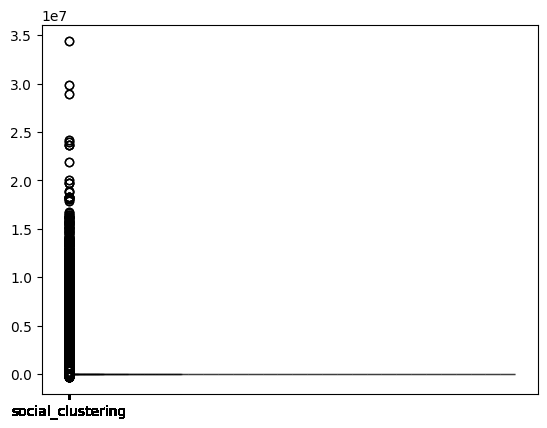

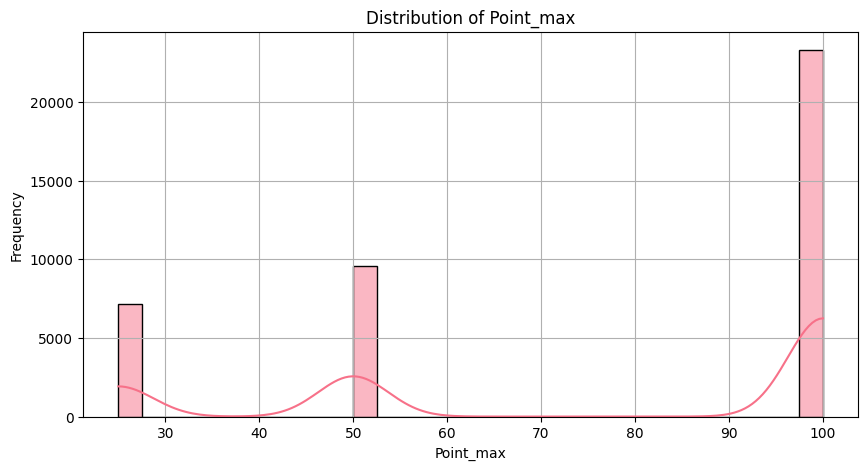

time: 51.4 s (started: 2025-07-11 20:53:20 +08:00)


In [98]:
# Example usage
if __name__ == "__main__":
    # Load your DataFrame here
    eda = ComprehensiveEDA()
    results = eda.analyze_dataframe(train_final)
    
    # Print summary of results
    print("EDA Results Summary:")
    print(results)